In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1233)
tf.random.set_seed(1233)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

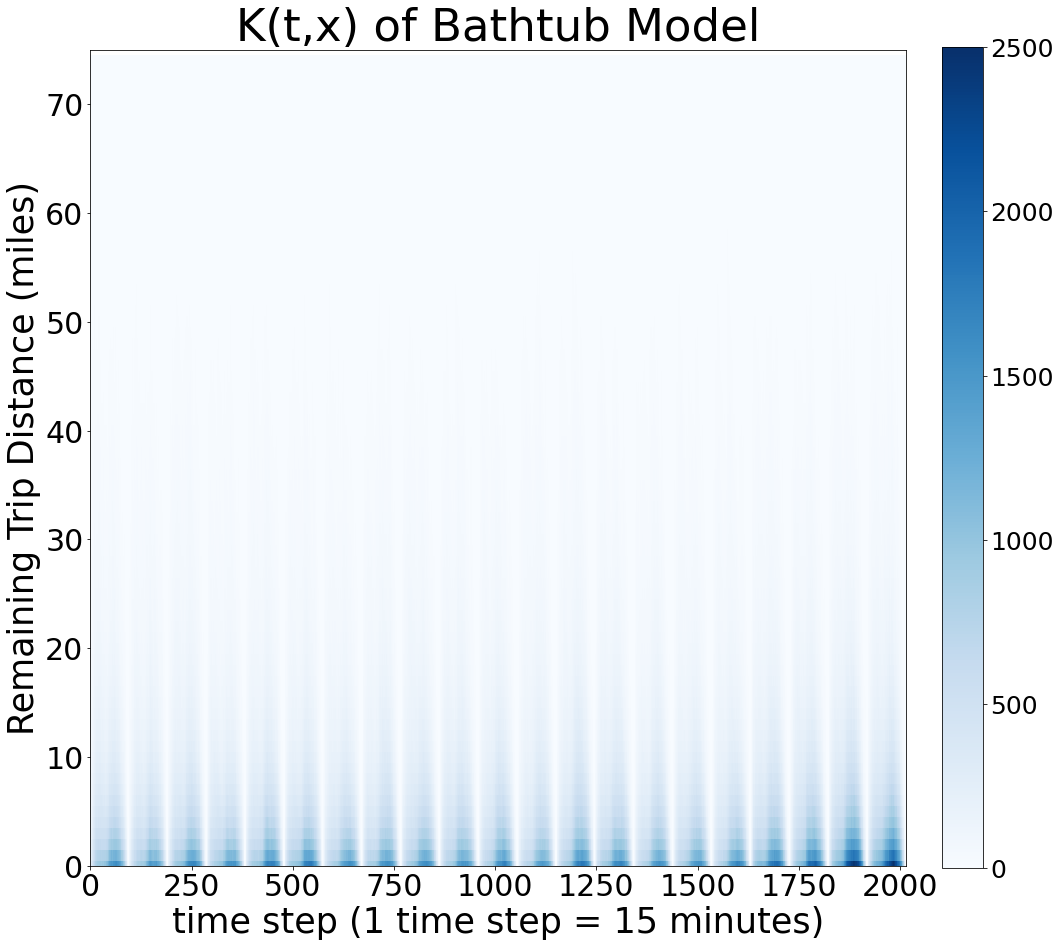

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 3 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  50400
N_u =  10080
N_f =  20160


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1233)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(10080, 2)

In [12]:
X_u_test.shape

(40320, 2)

In [13]:
X_u_train

array([[0.16216216, 0.47047146],
       [0.72972973, 0.80049628],
       [0.12162162, 0.40942928],
       ...,
       [0.08108108, 0.59503722],
       [0.24324324, 0.88188586],
       [0.36486486, 0.97766749]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u
    
    def loss(self,x,y):

        loss_u = self.loss_BC(x,y)

        loss = loss_u

        return loss, loss_u
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u= self.loss(X_u_train, u_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u = self.loss(X_u_train, u_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        
        tf.print(loss_value, loss_u, error_vec)

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.00883295188061151 0.00883295188061151 0.8315626996604932
0.0080097245253631724 0.0080097245253631724 0.7904104582214887
0.0074739100048995047 0.0074739100048995047 0.7619962652063582
0.0074344874960588381 0.0074344874960588381 0.7603093642152027
0.0073718160467682531 0.0073718160467682531 0.7578247311687508
0.0073240205013478049 0.0073240205013478049 0.7557143180509346
0.0071175197623696918 0.0071175197623696918 0.74601421706333
0.0068765899879315818 0.0068765899879315818 0.7345395983942871
0.006690588845491118 0.006690588845491118 0.7256041462286703
0.0063909651160339413 0.0063909651160339413 0.7090279986959982
0.0060400529300581682 0.0060400529300581682 0.6868521685828092
0.0059965415233976995 0.0059965415233976995 0.6844540103216578
0.0059722228975014049 0.0059722228975014049 0.6830889402609596
0.0059533927747696027 0.0059533927747696027 0.6821049924383857
0.0058952466026293048 0.0058952466026293048 0.6793798124835224
0.005796213132650275 0.005796213132650275 0.6744517272081988
0.

0.0023430137942277857 0.0023430137942277857 0.4382702574485787
0.0023427845522490717 0.0023427845522490717 0.4381878822877441
0.0023422005191955173 0.0023422005191955173 0.43798040296214547
0.0023416987478703279 0.0023416987478703279 0.4378259993963943
0.0023398522564889177 0.0023398522564889177 0.4375560515123165
0.002338029446076213 0.002338029446076213 0.4373308344806106
0.0023351594717091707 0.0023351594717091707 0.4371551838472159
0.0023325873275122366 0.0023325873275122366 0.4366835270851794
0.0023316908635604449 0.0023316908635604449 0.43650518270149796
0.0023309415010563227 0.0023309415010563227 0.43637261612888345
0.0023299916563104578 0.0023299916563104578 0.4364121544815888
0.002328904578816589 0.002328904578816589 0.43615163722295647
0.0023284528409683075 0.0023284528409683075 0.4360045168700932
0.00232795305220855 0.00232795305220855 0.4358889299583391
0.002327556344048467 0.002327556344048467 0.4357989079703199
0.0023272489179607596 0.0023272489179607596 0.435727974163630

0.0023000807630270083 0.0023000807630270083 0.43359468243054405
0.0022999598818275431 0.0022999598818275431 0.4336190299083545
0.0022997696028346937 0.0022997696028346937 0.43376520364772175
0.0022995743017677518 0.0022995743017677518 0.4338533553616731
0.0022992495681076089 0.0022992495681076089 0.4336673872077256
0.0022989280749541098 0.0022989280749541098 0.43359201617888715
0.0022986805992664711 0.0022986805992664711 0.43353056265603385
0.0022983745144694798 0.0022983745144694798 0.43344835744000876
0.0022981740653866519 0.0022981740653866519 0.433368734206827
0.0022975442880285614 0.0022975442880285614 0.43332532486481146
0.0022968841481376973 0.0022968841481376973 0.43333779716932763
0.0022947288562893461 0.0022947288562893461 0.4331044925013991
0.0022919688059246787 0.0022919688059246787 0.43261571724260467
0.0022906089924132384 0.0022906089924132384 0.43247017788308806
0.0022904965962112942 0.0022904965962112942 0.43253330060270484
0.0022901781361931921 0.0022901781361931921 0.

0.0022714224677390735 0.0022714224677390735 0.43321668486828263
0.0022710163675090547 0.0022710163675090547 0.4331297792063478
0.002270468994711864 0.002270468994711864 0.43307342484645767
0.002270198271061953 0.002270198271061953 0.4330864011951256
0.0022699902877753105 0.0022699902877753105 0.4331502047084794
0.0022698298806810235 0.0022698298806810235 0.43316691673453483
0.0022696114729947939 0.0022696114729947939 0.433236973356928
0.0022694096391377319 0.0022694096391377319 0.43329557775580013
0.0022691367286492973 0.0022691367286492973 0.4334269394664146
0.0022689796700850256 0.0022689796700850256 0.43352477171373727
0.0022689307952500227 0.0022689307952500227 0.43355646240150353
0.0022688703856629487 0.0022688703856629487 0.4335448838483903
0.002268820009535902 0.002268820009535902 0.4335243471487065
0.0022687644072782536 0.0022687644072782536 0.43351503750847853
0.0022687157880323604 0.0022687157880323604 0.4334900980638448
0.002268631439688717 0.002268631439688717 0.43351748487

0.0022444675789327234 0.0022444675789327234 0.43382868715465583
0.002244120726168333 0.002244120726168333 0.4336891218710111
0.0022439841922666428 0.0022439841922666428 0.4336848503103766
0.0022439147931582358 0.0022439147931582358 0.43371391563114114
0.0022438992285853 0.0022438992285853 0.4337452705502574
0.0022438499812078212 0.0022438499812078212 0.4337434766098357
0.0022438122865562171 0.0022438122865562171 0.4337114566085496
0.0022437270346329862 0.0022437270346329862 0.4337513637919477
0.002243565685366225 0.002243565685366225 0.43377447416675297
0.0022433875178496433 0.0022433875178496433 0.43379075706151765
0.0022432593933631919 0.0022432593933631919 0.4337564237894353
0.0022431688845687969 0.0022431688845687969 0.43374751690133156
0.0022430897346413857 0.0022430897346413857 0.43373798515830597
0.0022429700275702919 0.0022429700275702919 0.43373025340993016
0.0022424181455546516 0.0022424181455546516 0.433690238108247
0.00224214370968299 0.00224214370968299 0.4336478148011548


0.0022220408505395171 0.0022220408505395171 0.4352280649521198
0.0022220237366167694 0.0022220237366167694 0.4351763170800282
0.0022220175949653745 0.0022220175949653745 0.4351077879942465
0.0022220036048329651 0.0022220036048329651 0.4351082825881844
0.0022219961592612886 0.0022219961592612886 0.43508638327044474
0.0022219891981415376 0.0022219891981415376 0.43506887092499985
0.0022219756717405466 0.0022219756717405466 0.435034033089326
0.0022219541862708156 0.0022219541862708156 0.4349981769451777
0.002221904915117443 0.002221904915117443 0.43492874968273243
0.0022218664470097511 0.0022218664470097511 0.4348550079891729
0.0022218208454660941 0.0022218208454660941 0.43482118532016795
0.0022217859588307847 0.0022217859588307847 0.434822427207674
0.0022217467778746758 0.0022217467778746758 0.4348360624532002
0.0022217282717295131 0.0022217282717295131 0.4348701997546926
0.0022217111526305036 0.0022217111526305036 0.4348833497576548
0.0022216948870826597 0.0022216948870826597 0.434876160

0.0022149972161498569 0.0022149972161498569 0.4344939482333124
0.002214862391738826 0.002214862391738826 0.43449696449850905
0.0022146822335718046 0.0022146822335718046 0.43451154640280515
0.0022144207206820431 0.0022144207206820431 0.434588855008679
0.0022141269915982738 0.0022141269915982738 0.434639747938665
0.0022140084306062837 0.0022140084306062837 0.4345951650372936
0.0022137311803949612 0.0022137311803949612 0.43449356680903756
0.002213529794658792 0.002213529794658792 0.43452633707962174
0.0022131588908703755 0.0022131588908703755 0.43461511812096676
0.0022130122684561253 0.0022130122684561253 0.43464235593147454
0.002212607531529639 0.002212607531529639 0.4348819808405038
0.0022122059969000127 0.0022122059969000127 0.4346508317699922
0.0022119425008111419 0.0022119425008111419 0.43450238267867664
0.002211765218813369 0.002211765218813369 0.4344923257499391
0.0022114281814728 0.0022114281814728 0.43480741846184906
0.0022111626722686245 0.0022111626722686245 0.4345823680318771


0.0021794665542758597 0.0021794665542758597 0.4308799057584976
0.0021787344020200647 0.0021787344020200647 0.43095245250554876
0.002178370588535837 0.002178370588535837 0.43088705813052663
0.002177845210452856 0.002177845210452856 0.43069310132311384
0.002177362122246093 0.002177362122246093 0.43066214214718135
0.0021767700197870827 0.0021767700197870827 0.43061519544224997
0.0021756855216461036 0.0021756855216461036 0.43044752030627453
0.0021747597560786173 0.0021747597560786173 0.43042522015491713
0.002174114642859575 0.002174114642859575 0.4305560565349175
0.0021732664626657196 0.0021732664626657196 0.4304473203990337
0.0021726695063171977 0.0021726695063171977 0.4304194120451628
0.0021723002237305816 0.0021723002237305816 0.4301801805709957
0.0021713658336560363 0.0021713658336560363 0.4303868141219077
0.0021710302757061645 0.0021710302757061645 0.4303151900043565
0.0021706132721179693 0.0021706132721179693 0.4304166572988765
0.0021704138894826403 0.0021704138894826403 0.4304563217

0.0021513718884638143 0.0021513718884638143 0.42760446130370783
0.0021512663882927883 0.0021512663882927883 0.4276156341641257
0.00215107869475934 0.00215107869475934 0.42760998358262275
0.0021509029375321033 0.0021509029375321033 0.4275591083342215
0.002150809039489548 0.002150809039489548 0.4275467030509055
0.0021507649058224096 0.0021507649058224096 0.4275501110703895
0.0021506328231923728 0.0021506328231923728 0.4275009518567726
0.0021505093759177237 0.0021505093759177237 0.4274512949877263
0.00215038617012968 0.00215038617012968 0.42749066679919046
0.0021503460450139839 0.0021503460450139839 0.4275628316584446
0.0021502025407833165 0.0021502025407833165 0.42759453348983506
0.0021501279844896139 0.0021501279844896139 0.4274599568353281
0.0021500688400995912 0.0021500688400995912 0.42740672454196404
0.0021499758534506076 0.0021499758534506076 0.4273826975474154
0.0021499346075294868 0.0021499346075294868 0.4273728919463458
0.0021498635649032346 0.0021498635649032346 0.42735132560758

0.0021366458912274095 0.0021366458912274095 0.4277441571546355
0.0021366311011548665 0.0021366311011548665 0.42774899757769586
0.002136623292114359 0.002136623292114359 0.42769365673061865
0.0021366173305060209 0.0021366173305060209 0.4277490137346078
0.0021365999206535975 0.0021365999206535975 0.4277396297421022
0.0021365855659127167 0.0021365855659127167 0.42777658659136786
0.0021365645597435658 0.0021365645597435658 0.42772946074886253
0.00213655548496824 0.00213655548496824 0.42769542495871976
0.0021365429158692289 0.0021365429158692289 0.427623696747443
0.0021365323693288384 0.0021365323693288384 0.4275652853672374
0.0021364912254338412 0.0021364912254338412 0.42734859946965176
0.0021364237129905578 0.0021364237129905578 0.4273375550540771
0.0021363721938920115 0.0021363721938920115 0.42731505626685157
0.0021363111623018205 0.0021363111623018205 0.4273698595263032
0.0021362547686881732 0.0021362547686881732 0.4275628650008131
0.0021362316991331365 0.0021362316991331365 0.427611102

0.0021272912406201465 0.0021272912406201465 0.42778221940368333
0.0021272273733409317 0.0021272273733409317 0.42785190024244285
0.00212717306600984 0.00212717306600984 0.42788663006986566
0.0021271268604430905 0.0021271268604430905 0.4276950766846984
0.0021270616114307888 0.0021270616114307888 0.42761574556029197
0.0021269880026291059 0.0021269880026291059 0.42770653565952316
0.0021269260604811517 0.0021269260604811517 0.42775509265930445
0.002126887602082384 0.002126887602082384 0.42755277958939936
0.0021268368457777334 0.0021268368457777334 0.4274909818634535
0.002126767932274939 0.002126767932274939 0.427441363462968
0.0021265785381470929 0.0021265785381470929 0.42742075784487843
0.0021263115997603088 0.0021263115997603088 0.42751420079612545
0.0021260108196905591 0.0021260108196905591 0.42782981330367414
0.0021258979967536747 0.0021258979967536747 0.4279518482777741
0.0021256135807420722 0.0021256135807420722 0.42831471994083203
0.0021253452750465804 0.0021253452750465804 0.4278154

0.0021108186646357778 0.0021108186646357778 0.42566886707702434
0.0021105960138171503 0.0021105960138171503 0.4256577650136372
0.0021104559868536051 0.0021104559868536051 0.42557132446029894
0.002110342881381485 0.002110342881381485 0.42528835708516255
0.0021099853948918705 0.0021099853948918705 0.4253037281339246
0.002109745347535219 0.002109745347535219 0.4252084555506643
0.0021095544898611113 0.0021095544898611113 0.42507099796256476
0.0021092574347429151 0.0021092574347429151 0.4249581749924696
0.002108936641968877 0.002108936641968877 0.4249087775996941
0.0021086558789968081 0.0021086558789968081 0.42488806741283425
0.0021084032841707638 0.0021084032841707638 0.4247215515741486
0.0021082292785785492 0.0021082292785785492 0.4246933339937401
0.0021079270001762448 0.0021079270001762448 0.42485509602248156
0.0021077495026045438 0.0021077495026045438 0.42520407405581234
0.0021076589347053584 0.0021076589347053584 0.4256269632465436
0.0021073785484570936 0.0021073785484570936 0.42526068

0.0020538334729367229 0.0020538334729367229 0.4211241036085402
0.002053702438937191 0.002053702438937191 0.4211964331683643
0.0020533545669401154 0.0020533545669401154 0.42137572869463547
0.00205314643353105 0.00205314643353105 0.42126195995590165
0.0020530385408424998 0.0020530385408424998 0.42120522901506297
0.0020528291931176932 0.0020528291931176932 0.4210140272554203
0.0020524690784577905 0.0020524690784577905 0.42079201355752927
0.002052042298584749 0.002052042298584749 0.4207612632382575
0.0020513721221678042 0.0020513721221678042 0.42046353728171126
0.0020508923057560532 0.0020508923057560532 0.4207733934486631
0.0020498286511911809 0.0020498286511911809 0.4206695026744923
0.0020491704151134132 0.0020491704151134132 0.4208555765583992
0.0020484131895068549 0.0020484131895068549 0.4207926113379349
0.0020479604125904359 0.0020479604125904359 0.41979533314622547
0.002047170935207602 0.002047170935207602 0.4198095546307338
0.002046769066206211 0.002046769066206211 0.419510699016758

0.0019922086350682108 0.0019922086350682108 0.4153446054875415
0.0019920204725408972 0.0019920204725408972 0.41527137501196526
0.0019917358062385487 0.0019917358062385487 0.4153414013589851
0.00199139479779085 0.00199139479779085 0.41549508878075186
0.0019911964846060421 0.0019911964846060421 0.41550951509959455
0.0019908879627207757 0.0019908879627207757 0.41553719196952954
0.0019903312284780933 0.0019903312284780933 0.4155640171400237
0.0019899638178813221 0.0019899638178813221 0.41563302179465783
0.0019896851984875829 0.0019896851984875829 0.4157320862575221
0.0019893929231295892 0.0019893929231295892 0.4157268963800222
0.0019888704297587097 0.0019888704297587097 0.41553729480981344
0.0019884909915402651 0.0019884909915402651 0.41554847963336305
0.0019881393369413341 0.0019881393369413341 0.4155477190576151
0.0019879150963663878 0.0019879150963663878 0.4156053541335821
0.0019875418460447566 0.0019875418460447566 0.4157531201383536
0.0019871664393410968 0.0019871664393410968 0.415834

0.0019704314743782792 0.0019704314743782792 0.4143166479465887
0.0019703851249487023 0.0019703851249487023 0.4143002642033904
0.001970316109542685 0.001970316109542685 0.41433830946279065
0.0019702716943176728 0.0019702716943176728 0.41436219106306926
0.0019702273431380459 0.0019702273431380459 0.414412664281063
0.0019702115969125874 0.0019702115969125874 0.414387861573724
0.0019701754768457307 0.0019701754768457307 0.414377235618712
0.0019701365180567658 0.0019701365180567658 0.41430753392480324
0.0019701069757500434 0.0019701069757500434 0.41430130600277765
0.0019700848001020311 0.0019700848001020311 0.41429041790836374
0.0019700519353450805 0.0019700519353450805 0.41421870192075017
0.0019700227654249388 0.0019700227654249388 0.41421807572404307
0.0019699464846914976 0.0019699464846914976 0.41419555250536877
0.0019698747357802123 0.0019698747357802123 0.41412047107540334
0.0019698335365580604 0.0019698335365580604 0.4140860664598812
0.0019697323888865268 0.0019697323888865268 0.41403

0.0019599773719471305 0.0019599773719471305 0.41125187994822304
0.0019599192723090179 0.0019599192723090179 0.4112785734432719
0.001959800618990926 0.001959800618990926 0.4113951350587963
0.0019597610918086019 0.0019597610918086019 0.41129318904914747
0.0019597246906995712 0.0019597246906995712 0.4112635736833414
0.0019596813705889055 0.0019596813705889055 0.41127359583032275
0.0019596610686711639 0.0019596610686711639 0.4112816211836639
0.0019596360808712865 0.0019596360808712865 0.41128418643670545
0.0019596116437999491 0.0019596116437999491 0.41129132121852996
0.0019595789733091945 0.0019595789733091945 0.41126317329909085
0.0019595399577117486 0.0019595399577117486 0.41115290830024354
0.0019594854060002651 0.0019594854060002651 0.41104034824417257
0.0019594460262820097 0.0019594460262820097 0.41096552372038386
0.0019594122799391125 0.0019594122799391125 0.4109817056754505
0.001959379596207185 0.001959379596207185 0.41095953997355633
0.0019593048371530329 0.0019593048371530329 0.410

0.001935445776130997 0.001935445776130997 0.40584744007166834
0.0019345781720907485 0.0019345781720907485 0.4054878136486635
0.0019338874835742456 0.0019338874835742456 0.4055734803566787
0.0019326974905417105 0.0019326974905417105 0.40527595583116055
0.0019321068123352846 0.0019321068123352846 0.4050382091235264
0.00193124696298011 0.00193124696298011 0.40539980342606186
0.0019303239098012581 0.0019303239098012581 0.40508040142906193
0.0019293947766749937 0.0019293947766749937 0.4049742237753384
0.0019285214852985248 0.0019285214852985248 0.40489476533591295
0.0019279665470753001 0.0019279665470753001 0.404870414568846
0.00192718809479732 0.00192718809479732 0.40466524708678114
0.0019269927596424605 0.0019269927596424605 0.4048497943581957
0.0019262820089427841 0.0019262820089427841 0.4047693736162234
0.0019255893570726912 0.0019255893570726912 0.40486194784350893
0.0019254205492573863 0.0019254205492573863 0.40454974070538796
0.0019248223913606618 0.0019248223913606618 0.404697474678

0.0018808207231167809 0.0018808207231167809 0.39720272919232935
0.0018806408784388308 0.0018806408784388308 0.3972084951961006
0.0018804305813157436 0.0018804305813157436 0.3971858242011288
0.0018802628364740126 0.0018802628364740126 0.39715233584835674
0.0018801004345385132 0.0018801004345385132 0.3971588466457538
0.0018798925632623382 0.0018798925632623382 0.39705797042779667
0.001879862290707105 0.001879862290707105 0.3970601981359664
0.0018796230343963807 0.0018796230343963807 0.39705992914528404
0.0018795508848225839 0.0018795508848225839 0.3970481208627859
0.0018794379157013421 0.0018794379157013421 0.3970120986405533
0.0018793341231610132 0.0018793341231610132 0.39702074830083534
0.001879263604877801 0.001879263604877801 0.39697021249052
0.0018791666804560889 0.0018791666804560889 0.3969218146013978
0.0018790390376023966 0.0018790390376023966 0.396959301144984
0.0018789285073708259 0.0018789285073708259 0.3969911073811374
0.0018787220833187358 0.0018787220833187358 0.39703352710

0.0018712705543382229 0.0018712705543382229 0.3961192497491678
0.0018712339045029993 0.0018712339045029993 0.3961016454477116
0.0018712009902515155 0.0018712009902515155 0.39608178240853625
0.0018711594231650393 0.0018711594231650393 0.39611572959675023
0.0018711409262530219 0.0018711409262530219 0.3961291848413664
0.0018711241578813803 0.0018711241578813803 0.3961341566095515
0.0018711061496384555 0.0018711061496384555 0.39616250642868517
0.0018710866859011426 0.0018710866859011426 0.39617790497323996
0.0018710717391326687 0.0018710717391326687 0.3961943849680862
0.0018710362871790511 0.0018710362871790511 0.3962313814765515
0.0018709919582500351 0.0018709919582500351 0.3962133872057343
0.0018709717277516262 0.0018709717277516262 0.39620330574567325
0.0018709494157542056 0.0018709494157542056 0.3962013685683376
0.001870936396401914 0.001870936396401914 0.39614751463912173
0.0018709152641456072 0.0018709152641456072 0.39613356094829477
0.0018708950970737492 0.0018708950970737492 0.3961

0.001868588688337138 0.001868588688337138 0.39571742336983373
0.001868566681790834 0.001868566681790834 0.3956903346199134
0.0018685397537898105 0.0018685397537898105 0.3956878803667496
0.0018684851418113504 0.0018684851418113504 0.39567080126038773
0.0018684547894438517 0.0018684547894438517 0.3957066397774519
0.0018684341537206115 0.0018684341537206115 0.3957350003639172
0.0018684142508671548 0.0018684142508671548 0.39574492911756415
0.0018683863997697875 0.0018683863997697875 0.3957842651370205
0.0018683618215943533 0.0018683618215943533 0.3957948138679632
0.001868311077706421 0.001868311077706421 0.3958004196217549
0.0018683002847889425 0.0018683002847889425 0.3958074945477173
0.0018682751783472473 0.0018682751783472473 0.3958153357817211
0.0018682538301799717 0.0018682538301799717 0.39582015601733567
0.001868243316600432 0.001868243316600432 0.395832663934461
0.0018682238372075479 0.0018682238372075479 0.3958476285637402
0.001868205676893814 0.001868205676893814 0.3958585428201178

0.0018658491611758948 0.0018658491611758948 0.3942153146318891
0.0018658421104903837 0.0018658421104903837 0.39420156776484605
0.0018658398917666917 0.0018658398917666917 0.39420909726056086
0.0018658343547283387 0.0018658343547283387 0.3942042091931874
0.0018658299844324456 0.0018658299844324456 0.3941894649646827
0.0018658244308753546 0.0018658244308753546 0.39417782309414373
0.0018658172619107421 0.0018658172619107421 0.3941836149835833
0.001865808201282401 0.001865808201282401 0.3942050080547915
0.0018658058145772272 0.0018658058145772272 0.3942372193075049
0.0018657982561738925 0.0018657982561738925 0.3942212295530262
0.0018657951653554988 0.0018657951653554988 0.39420906068904277
0.0018657884930912609 0.0018657884930912609 0.39417662151365535
0.0018657862907445742 0.0018657862907445742 0.3941606493245421
0.0018657765583493741 0.0018657765583493741 0.39415115618940544
0.0018657537142439337 0.0018657537142439337 0.39413453396585035
0.0018657340039972988 0.0018657340039972988 0.3941

0.0018644203933238684 0.0018644203933238684 0.39372248372429497
0.0018644023482895121 0.0018644023482895121 0.3937163814621609
0.0018643700223297318 0.0018643700223297318 0.39370202538093413
0.0018643411749431366 0.0018643411749431366 0.39371835869401023
0.0018643297443496133 0.0018643297443496133 0.3937113400072149
0.0018643033299422045 0.0018643033299422045 0.3936828927733567
0.0018642932758529661 0.0018642932758529661 0.3937113678016448
0.0018642804952321305 0.0018642804952321305 0.39376740540681926
0.0018642662161127712 0.0018642662161127712 0.3937615162612468
0.0018642604143904661 0.0018642604143904661 0.39374810443221564
0.001864247361182742 0.001864247361182742 0.39372627419914374
0.0018642440910801219 0.0018642440910801219 0.3937578598161106
0.0018642364958239449 0.0018642364958239449 0.39374596236355475
0.0018642307694513541 0.0018642307694513541 0.39373368352316535
0.0018642276207825406 0.0018642276207825406 0.3937344222465096
0.0018642263769273692 0.0018642263769273692 0.393

0.0018587097880907765 0.0018587097880907765 0.3924293238046222
0.0018586589025932846 0.0018586589025932846 0.3924736177902648
0.0018586293179099658 0.0018586293179099658 0.3924807963318591
0.0018586002958099514 0.0018586002958099514 0.3924993971102524
0.0018585802798766779 0.0018585802798766779 0.3925171986429056
0.001858551919753715 0.001858551919753715 0.39251474015660187
0.0018585262841322857 0.0018585262841322857 0.39251222049069706
0.0018585108305037424 0.0018585108305037424 0.3924918671387008
0.0018584962254120886 0.0018584962254120886 0.392486869018641
0.001858481683770829 0.001858481683770829 0.39252848292107173
0.0018584638668379093 0.0018584638668379093 0.39250884390164914
0.0018584518703561007 0.0018584518703561007 0.39253929541549953
0.0018584420494446234 0.0018584420494446234 0.3925559891170775
0.0018584301299916953 0.0018584301299916953 0.3925711340197287
0.0018584192138794177 0.0018584192138794177 0.39256026830345453
0.0018584094788713663 0.0018584094788713663 0.39253589

0.0018563678080483672 0.0018563678080483672 0.3918664513801097
0.0018563434874501103 0.0018563434874501103 0.3918529085395152
0.0018563101447428756 0.0018563101447428756 0.3918498000993929
0.0018562851342764464 0.0018562851342764464 0.3918620886937484
0.0018562601077189533 0.0018562601077189533 0.39187869106557716
0.0018562048377432302 0.0018562048377432302 0.39188986928015995
0.0018561872912775741 0.0018561872912775741 0.39181490429729593
0.0018561312220045469 0.0018561312220045469 0.3917552638079651
0.0018560961378732554 0.0018560961378732554 0.39176517038699377
0.0018560647928947108 0.0018560647928947108 0.39176090742469893
0.0018560158353004242 0.0018560158353004242 0.39175249709141086
0.0018559776620235779 0.0018559776620235779 0.39172140012087125
0.0018558729739234969 0.0018558729739234969 0.3916902450415282
0.0018558045114383274 0.0018558045114383274 0.39166943099805424
0.0018557359670938484 0.0018557359670938484 0.3916474664196587
0.0018556442562444994 0.0018556442562444994 0.3

0.0018488811491019937 0.0018488811491019937 0.38960197295574767
0.0018488233807110105 0.0018488233807110105 0.38960114837783844
0.0018487657444286089 0.0018487657444286089 0.3896525291709477
0.0018487158660397732 0.0018487158660397732 0.38967642885930875
0.0018486358689623092 0.0018486358689623092 0.3896989778530035
0.0018486214848335869 0.0018486214848335869 0.38970220054055854
0.0018485814011235376 0.0018485814011235376 0.38971918914372555
0.0018485577615534362 0.0018485577615534362 0.3896941081900183
0.0018485535524022834 0.0018485535524022834 0.3896541021792789
0.0018485407248436949 0.0018485407248436949 0.3896584832149251
0.0018485350636110172 0.0018485350636110172 0.389676313187586
0.0018485280018631718 0.0018485280018631718 0.38967095130074786
0.0018485132899511952 0.0018485132899511952 0.3896885667236844
0.0018485068216328923 0.0018485068216328923 0.3896897409610108
0.0018484962146519957 0.0018484962146519957 0.3896798109841396
0.0018484868480605839 0.0018484868480605839 0.3896

0.00184467158267011 0.00184467158267011 0.3894399199448369
0.0018446480526212159 0.0018446480526212159 0.3894076374452979
0.0018446272099193898 0.0018446272099193898 0.3894383121470214
0.0018446051586419529 0.0018446051586419529 0.38944832169976423
0.0018445957827322535 0.0018445957827322535 0.38943908969658336
0.001844582118671758 0.001844582118671758 0.38941612521127716
0.0018445719909174086 0.0018445719909174086 0.38939370930353756
0.0018445506641984735 0.0018445506641984735 0.3894028206312937
0.0018445072681931196 0.0018445072681931196 0.38946506003849213
0.0018444966263897488 0.0018444966263897488 0.3894648294377406
0.0018444717657383502 0.0018444717657383502 0.38949394873670795
0.0018444513817463095 0.0018444513817463095 0.3894784823533944
0.0018444341863511498 0.0018444341863511498 0.3894740183128264
0.0018444180872979592 0.0018444180872979592 0.38947967970843356
0.0018444053149619852 0.0018444053149619852 0.38947908739777093
0.00184439720120006 0.00184439720120006 0.38946024393

0.0018428416942459583 0.0018428416942459583 0.3893920431871356
0.0018428380166415259 0.0018428380166415259 0.3893818687708429
0.0018428363358254207 0.0018428363358254207 0.3893916588070678
0.0018428330543251666 0.0018428330543251666 0.38940030923703156
0.0018428308292565685 0.0018428308292565685 0.3893921144488123
0.0018428246949691439 0.0018428246949691439 0.38940878439035076
0.0018428181784798867 0.0018428181784798867 0.3894232705142684
0.0018428147771417549 0.0018428147771417549 0.38942954003966884
0.0018428042088633949 0.0018428042088633949 0.38943385698092287
0.0018427862759933784 0.0018427862759933784 0.38943034339409915
0.0018427685538054573 0.0018427685538054573 0.3894230292391623
0.0018427537642177938 0.0018427537642177938 0.3893989105519112
0.0018427498625713501 0.0018427498625713501 0.3893766414390548
0.0018427289602187895 0.0018427289602187895 0.3893884791158485
0.0018427225675633394 0.0018427225675633394 0.3893680932123027
0.0018427035325669543 0.0018427035325669543 0.3894

0.0018403193719852128 0.0018403193719852128 0.38982270462134844
0.0018402852791399079 0.0018402852791399079 0.3898185605425299
0.0018402661593129544 0.0018402661593129544 0.389809865291987
0.0018402479684583868 0.0018402479684583868 0.38980082098814917
0.00184022890740291 0.00184022890740291 0.3898148490809287
0.001840206296964058 0.001840206296964058 0.3898203419765057
0.0018401692461372183 0.0018401692461372183 0.38981083283058265
0.0018401365014584345 0.0018401365014584345 0.3898087660499436
0.0018401031239361626 0.0018401031239361626 0.38982324790911943
0.0018400920922215294 0.0018400920922215294 0.3896898183734669
0.0018400630697957645 0.0018400630697957645 0.3897142131615894
0.0018400342660006997 0.0018400342660006997 0.38974671152159257
0.0018400115709093713 0.0018400115709093713 0.38975204794225243
0.0018399829465740344 0.0018399829465740344 0.3896941676818011
0.0018399358929814876 0.0018399358929814876 0.3896116059622512
0.0018398819806899986 0.0018398819806899986 0.3895586634

0.0018383889280780988 0.0018383889280780988 0.3894786243765593
0.0018383727266668519 0.0018383727266668519 0.3894982667126044
0.0018383519883842096 0.0018383519883842096 0.3895246199229129
0.0018383379074006787 0.0018383379074006787 0.3895201820489515
0.0018383142181411462 0.0018383142181411462 0.3895875770911957
0.0018382955905202069 0.0018382955905202069 0.3896296140887722
0.0018382661890666379 0.0018382661890666379 0.3895517575733829
0.0018382356105254628 0.0018382356105254628 0.3895415738601668
0.0018382180275026614 0.0018382180275026614 0.38955718435045045
0.001838198366804334 0.001838198366804334 0.38954143381827167
0.0018381524151122285 0.0018381524151122285 0.3894885556754046
0.0018381225845988463 0.0018381225845988463 0.3894621464041899
0.0018381199536658789 0.0018381199536658789 0.3893820933925535
0.001838086954977691 0.001838086954977691 0.3893972174683779
0.0018380785463410377 0.0018380785463410377 0.38940232748661696
0.00183806699957252 0.00183806699957252 0.38941356204801

0.0018354988057431684 0.0018354988057431684 0.38855364762164485
0.0018354883973671294 0.0018354883973671294 0.3885743488513446
0.00183547702199614 0.00183547702199614 0.3885395029221901
0.0018354666069185298 0.0018354666069185298 0.3885288555881137
0.0018354526795776812 0.0018354526795776812 0.3885211437172999
0.0018354348689477477 0.0018354348689477477 0.3884956971939346
0.0018353990751086883 0.0018353990751086883 0.3884853769002414
0.0018353772373817859 0.0018353772373817859 0.3884506965336983
0.0018353075687847584 0.0018353075687847584 0.3884565899999615
0.0018352175945905666 0.0018352175945905666 0.3884029660535664
0.0018351006973173537 0.0018351006973173537 0.38855116122321093
0.00183502560946627 0.00183502560946627 0.3885808071820302
0.0018350033476294829 0.0018350033476294829 0.3885875994336958
0.0018349351008289227 0.0018349351008289227 0.38859316203447053
0.001834879521703458 0.001834879521703458 0.3885752354793296
0.0018347688661056647 0.0018347688661056647 0.3886178342914675

0.0018320697693109556 0.0018320697693109556 0.3887472738397239
0.0018320663707550235 0.0018320663707550235 0.38876953386541796
0.001832052787772131 0.001832052787772131 0.38879899070178986
0.0018320449903984292 0.0018320449903984292 0.38881543550739467
0.0018320286462801742 0.0018320286462801742 0.3888227958361002
0.0018319896674738603 0.0018319896674738603 0.3888735247133182
0.0018319484020423496 0.0018319484020423496 0.3889061713330568
0.0018318588193011066 0.0018318588193011066 0.388926827622381
0.0018318061220950824 0.0018318061220950824 0.3888971083307734
0.0018317530015167589 0.0018317530015167589 0.3888522855963854
0.0018317023931111094 0.0018317023931111094 0.3888336154362393
0.0018316579498786057 0.0018316579498786057 0.3888327916431187
0.0018316196151851754 0.0018316196151851754 0.38886337146806427
0.0018315424156477268 0.0018315424156477268 0.3888951352184914
0.0018315026004405539 0.0018315026004405539 0.3889211450133162
0.0018314180635348655 0.0018314180635348655 0.38892831

0.0018284098728677397 0.0018284098728677397 0.3898710902909143
0.0018284072309873709 0.0018284072309873709 0.3898670889544388
0.0018284006738252705 0.0018284006738252705 0.38989533315067376
0.0018283938853810389 0.0018283938853810389 0.38988748868299
0.0018283838613085894 0.0018283838613085894 0.38987819410100066
0.0018283748490560416 0.0018283748490560416 0.38986615373953976
0.0018283647105546473 0.0018283647105546473 0.3898135374543913
0.0018283479096913545 0.0018283479096913545 0.38979421860043645
0.0018283353315915406 0.0018283353315915406 0.389791258131306
0.0018283097930583245 0.0018283097930583245 0.38977156604025553
0.0018282938229604391 0.0018282938229604391 0.38979880785236337
0.0018282767243886066 0.0018282767243886066 0.389860040453152
0.0018282555723909588 0.0018282555723909588 0.3898835374126937
0.0018282437758459797 0.0018282437758459797 0.3898559204277044
0.0018282305506752115 0.0018282305506752115 0.3898588654796427
0.001828215854667075 0.001828215854667075 0.389875965

0.0018263112228069525 0.0018263112228069525 0.3901018772651854
0.001826283405081611 0.001826283405081611 0.3900838041342418
0.0018262428530292903 0.0018262428530292903 0.39002279242186344
0.0018261988676365386 0.0018261988676365386 0.390046490424377
0.0018261512859547692 0.0018261512859547692 0.39002618905686764
0.001826081787479314 0.001826081787479314 0.39002559407142207
0.0018260263053146654 0.0018260263053146654 0.3900831229842912
0.0018259585762784843 0.0018259585762784843 0.3900159721251915
0.0018259184278691287 0.0018259184278691287 0.3899718631545224
0.0018258709771150068 0.0018258709771150068 0.3899992166684137
0.0018257915606696433 0.0018257915606696433 0.39002722210708496
0.0018257145429822772 0.0018257145429822772 0.3900848005283185
0.001825683105185324 0.001825683105185324 0.39024736892895984
0.0018256081107152452 0.0018256081107152452 0.3901669929875582
0.0018255882404097025 0.0018255882404097025 0.3901438394423992
0.0018255358833352377 0.0018255358833352377 0.39014199759

0.0018224439667513645 0.0018224439667513645 0.38961092560412275
0.0018224108127288415 0.0018224108127288415 0.38962308993788763
0.0018223833394273104 0.0018223833394273104 0.389656198231081
0.0018223203065125546 0.0018223203065125546 0.3896449375510443
0.0018222363263264935 0.0018222363263264935 0.38961972488237734
0.0018221611405525122 0.0018221611405525122 0.3896033841427706
0.0018221178466946903 0.0018221178466946903 0.38960442110589383
0.0018220832453150124 0.0018220832453150124 0.38951456397346335
0.0018220046438747358 0.0018220046438747358 0.389535897080545
0.0018219964587098858 0.0018219964587098858 0.389577738441851
0.0018219036461149009 0.0018219036461149009 0.38956066514210386
0.0018218636673725031 0.0018218636673725031 0.38950541756205315
0.0018218200362888585 0.0018218200362888585 0.38949358796220157
0.0018217237544941494 0.0018217237544941494 0.3894599215067618
0.0018216229643146897 0.0018216229643146897 0.3894447348327058
0.0018215805794876362 0.0018215805794876362 0.3894

0.0018188543615467454 0.0018188543615467454 0.38981089787687
0.0018188475895628341 0.0018188475895628341 0.3898413421465664
0.0018188434259522714 0.0018188434259522714 0.3898252533049383
0.0018188394489773629 0.0018188394489773629 0.3898202024959256
0.0018188354550482478 0.0018188354550482478 0.3898115999877766
0.0018188315072023664 0.0018188315072023664 0.38980079327433886
0.0018188278352338179 0.0018188278352338179 0.3897871530869039
0.0018188225184103369 0.0018188225184103369 0.3897517200054893
0.0018188076826489675 0.0018188076826489675 0.3897548874862153
0.0018187928625748311 0.0018187928625748311 0.3897717898584068
0.0018187803741215353 0.0018187803741215353 0.389789420985297
0.001818776333684081 0.001818776333684081 0.38982975753242943
0.0018187604129114388 0.0018187604129114388 0.3898210539765903
0.0018187561584857414 0.0018187561584857414 0.3898074839992147
0.0018187509325462016 0.0018187509325462016 0.3898219112258015
0.0018187427335032559 0.0018187427335032559 0.389883877669

0.0018164233588292946 0.0018164233588292946 0.390184118045115
0.0018164132500800728 0.0018164132500800728 0.39018522135510875
0.001816404354597018 0.001816404354597018 0.3901940944231013
0.0018163998524639157 0.0018163998524639157 0.3901922210765987
0.0018163952078368375 0.0018163952078368375 0.3901888770127027
0.0018163915324020828 0.0018163915324020828 0.3901795324254304
0.001816385946433952 0.001816385946433952 0.3901595410359348
0.0018163779649959901 0.0018163779649959901 0.39013699391983436
0.001816372333486072 0.001816372333486072 0.390094676694472
0.0018163681054458262 0.0018163681054458262 0.3901022780988821
0.0018163646620444264 0.0018163646620444264 0.390107225031573
0.0018163622363197183 0.0018163622363197183 0.390097779738276
0.0018163599256415441 0.0018163599256415441 0.390090776812985
0.0018163551013642325 0.0018163551013642325 0.3900810271987921
0.0018163528723420903 0.0018163528723420903 0.39007717068900394
0.0018163405535442771 0.0018163405535442771 0.39008818323051153

0.0018128129242300233 0.0018128129242300233 0.3907815797694736
0.0018127586510792936 0.0018127586510792936 0.3907953385788965
0.0018126751324090023 0.0018126751324090023 0.3908116417054217
0.0018126050681513386 0.0018126050681513386 0.3908046255668245
0.0018124750197707868 0.0018124750197707868 0.3908046673194919
0.0018123846464074204 0.0018123846464074204 0.39076697578178665
0.0018123271793811719 0.0018123271793811719 0.39075144130925843
0.0018122715114999239 0.0018122715114999239 0.3907090878657039
0.001812205881345295 0.001812205881345295 0.39076577329618595
0.0018121733239896821 0.0018121733239896821 0.3906848162321543
0.0018121087490872009 0.0018121087490872009 0.3906368585372448
0.0018120526548174895 0.0018120526548174895 0.3906751448467153
0.0018119912433526121 0.0018119912433526121 0.39065898477242306
0.0018119060480162102 0.0018119060480162102 0.39060251666831036
0.0018118651057631126 0.0018118651057631126 0.3905099898297684
0.0018117641550800265 0.0018117641550800265 0.390474

0.0018059682119043949 0.0018059682119043949 0.3888820151122885
0.0018059502679587992 0.0018059502679587992 0.38886359080245747
0.0018059324466992417 0.0018059324466992417 0.3888592137589974
0.0018059270644388513 0.0018059270644388513 0.38885785257419686
0.0018059161177706414 0.0018059161177706414 0.38884910917473536
0.0018059053843507164 0.0018059053843507164 0.3888248779294952
0.0018058768540222974 0.0018058768540222974 0.38884267930412014
0.0018058499017110151 0.0018058499017110151 0.38883451148153336
0.0018058193850073506 0.0018058193850073506 0.3888262085824448
0.0018057937499827835 0.0018057937499827835 0.3887797234667075
0.0018057667428991943 0.0018057667428991943 0.38881459858493844
0.0018057502948748553 0.0018057502948748553 0.38883190919374755
0.00180572316597822 0.00180572316597822 0.3888258896756984
0.001805661668359655 0.001805661668359655 0.38879963348247404
0.0018055979255359286 0.0018055979255359286 0.3887558528439862
0.0018055062465036815 0.0018055062465036815 0.3887145

0.0017828411893539482 0.0017828411893539482 0.3868632777391797
0.0017826323271767002 0.0017826323271767002 0.3867303311812726
0.001782528157171889 0.001782528157171889 0.3866734495420959
0.0017823630320506357 0.0017823630320506357 0.3866487496808399
0.0017822363970234779 0.0017822363970234779 0.3866350378166664
0.0017821818805557673 0.0017821818805557673 0.38661928266739953
0.0017820693204264795 0.0017820693204264795 0.38659268693139154
0.0017819496409292067 0.0017819496409292067 0.386567386418961
0.0017818395839887145 0.0017818395839887145 0.3864792950066716
0.0017817531103882143 0.0017817531103882143 0.38649882782956324
0.0017817088358377017 0.0017817088358377017 0.38646258893323604
0.0017816860604037642 0.0017816860604037642 0.3864365478239832
0.0017816187462381633 0.0017816187462381633 0.38644266367415897
0.0017815648900191571 0.0017815648900191571 0.38641533211454215
0.0017814637340901793 0.0017814637340901793 0.3863970225411016
0.0017813709302203029 0.0017813709302203029 0.386373

0.0017787938321695983 0.0017787938321695983 0.385582845393789
0.0017787710853249879 0.0017787710853249879 0.3855797075332922
0.0017787430177492866 0.0017787430177492866 0.38556748536321434
0.0017787256957366472 0.0017787256957366472 0.3855051665653666
0.001778694719984295 0.001778694719984295 0.3855195465649397
0.0017786767386933407 0.0017786767386933407 0.3855267004675249
0.0017786535018431062 0.0017786535018431062 0.3855417029115502
0.0017786308410345077 0.0017786308410345077 0.38552937782701807
0.0017785924305572774 0.0017785924305572774 0.38553280860966105
0.0017785632914413393 0.0017785632914413393 0.3855247685377201
0.0017785354821664272 0.0017785354821664272 0.38554036524674523
0.0017785068156964915 0.0017785068156964915 0.385538631235893
0.0017784701636180554 0.0017784701636180554 0.3855318331316276
0.0017784499361382683 0.0017784499361382683 0.38555986950365395
0.0017784149559407826 0.0017784149559407826 0.385572426613129
0.0017784009485277512 0.0017784009485277512 0.385591496

0.0017741467374270121 0.0017741467374270121 0.38557647940612955
0.0017739825575203644 0.0017739825575203644 0.38560432533108263
0.0017739086177079597 0.0017739086177079597 0.3857355160788896
0.0017736683377754284 0.0017736683377754284 0.38567338881028507
0.001773522964845992 0.001773522964845992 0.3856911115915266
0.0017733885167903218 0.0017733885167903218 0.38557567264618103
0.0017733044084695918 0.0017733044084695918 0.3855709005397967
0.0017732504634095801 0.0017732504634095801 0.38565314696614594
0.001773161446969838 0.001773161446969838 0.3856451248898162
0.0017731186368236574 0.0017731186368236574 0.38564891215279207
0.0017730819334748629 0.0017730819334748629 0.38566706311098087
0.0017730484965223453 0.0017730484965223453 0.3856897532673614
0.0017730116778660429 0.0017730116778660429 0.3856899077268956
0.0017729814581530531 0.0017729814581530531 0.3856913465507747
0.0017729787298338261 0.0017729787298338261 0.38566116834008146
0.0017729572854967629 0.0017729572854967629 0.38567

0.0017681385450929032 0.0017681385450929032 0.3845562706307165
0.0017681359987585083 0.0017681359987585083 0.38455286568589936
0.0017681332771419776 0.0017681332771419776 0.38455092947551195
0.0017681287298305676 0.0017681287298305676 0.3845477118809835
0.0017681251082153767 0.0017681251082153767 0.38455962132974986
0.0017681194849373438 0.0017681194849373438 0.3845595698655837
0.0017681135897552119 0.0017681135897552119 0.384572129569057
0.001768105792516825 0.001768105792516825 0.38459954425912035
0.0017680987643032052 0.0017680987643032052 0.38460885773147396
0.0017680895971565168 0.0017680895971565168 0.38461210998474754
0.001768079161884286 0.001768079161884286 0.3846145926441276
0.0017680670150239477 0.0017680670150239477 0.38460451145238495
0.0017680567707325527 0.0017680567707325527 0.3846175682843271
0.0017680372764692816 0.0017680372764692816 0.38464246494782595
0.0017680160703755854 0.0017680160703755854 0.38464279018061137
0.0017679983790255169 0.0017679983790255169 0.38463

0.0017600423182497556 0.0017600423182497556 0.3831983098630659
0.0017600148824013018 0.0017600148824013018 0.3831724604177623
0.0017599796016212984 0.0017599796016212984 0.3831509726200607
0.0017599336586414805 0.0017599336586414805 0.38314876750192445
0.0017598912717922391 0.0017598912717922391 0.38313968514064684
0.0017598499071567377 0.0017598499071567377 0.3830609352835463
0.0017597923391385899 0.0017597923391385899 0.3830265955158694
0.0017597607868635352 0.0017597607868635352 0.38310427118968715
0.0017597272744319711 0.0017597272744319711 0.38307083162355193
0.0017597150227927037 0.0017597150227927037 0.3830282616245504
0.0017596867822537174 0.0017596867822537174 0.3830430708408636
0.0017596636528934711 0.0017596636528934711 0.38306923430079853
0.0017596301399836305 0.0017596301399836305 0.3831513877821547
0.0017596074753102513 0.0017596074753102513 0.3831138697838034
0.00175958635486981 0.00175958635486981 0.3830316513392079
0.0017595479736226564 0.0017595479736226564 0.38306798

0.0017549717831433569 0.0017549717831433569 0.3829241359352686
0.0017549286887046046 0.0017549286887046046 0.3828836703802472
0.0017549219658634467 0.0017549219658634467 0.38288987108502165
0.0017548833696523745 0.0017548833696523745 0.3829296106397864
0.0017548580237220577 0.0017548580237220577 0.3829308547186705
0.0017548453091355022 0.0017548453091355022 0.38292800410494
0.001754814895541844 0.001754814895541844 0.3829382893371597
0.0017548067088917888 0.0017548067088917888 0.3829766188690177
0.0017547750840178498 0.0017547750840178498 0.38296402582254474
0.0017547538631901998 0.0017547538631901998 0.3829284222950134
0.00175473131234842 0.00175473131234842 0.38291893493241547
0.0017546956609331582 0.0017546956609331582 0.38289951594552357
0.0017546486128016932 0.0017546486128016932 0.3828523539857973
0.0017545947022607857 0.0017545947022607857 0.38285050870518106
0.0017545634903164994 0.0017545634903164994 0.38280966598688365
0.001754535098546956 0.001754535098546956 0.3827355368523

0.0017526490822894712 0.0017526490822894712 0.3822246459143382
0.0017526068118352994 0.0017526068118352994 0.3822952279762748
0.0017525736460029418 0.0017525736460029418 0.3823427662660877
0.0017525517144120707 0.0017525517144120707 0.38235480340340516
0.0017525303689498669 0.0017525303689498669 0.382318724863441
0.0017525177039376893 0.0017525177039376893 0.3823235212270184
0.0017524996640635529 0.0017524996640635529 0.3823301613510979
0.0017524835958762002 0.0017524835958762002 0.3823256861729718
0.0017524569777671443 0.0017524569777671443 0.3823060681947703
0.0017524285355213522 0.0017524285355213522 0.3823110017768516
0.0017524106240664869 0.0017524106240664869 0.3822902471879926
0.0017523989326316538 0.0017523989326316538 0.38229083938563446
0.0017523837287573088 0.0017523837287573088 0.38230158551943005
0.0017523582817683821 0.0017523582817683821 0.3823086210321424
0.0017523263447996992 0.0017523263447996992 0.3823159348670461
0.001752283405642838 0.001752283405642838 0.382299670

0.0017491410501071518 0.0017491410501071518 0.3821380808000059
0.0017491066914941825 0.0017491066914941825 0.3821513890602362
0.0017490360480757821 0.0017490360480757821 0.3821780507625529
0.0017489868692859736 0.0017489868692859736 0.38216183452292135
0.0017488861047701761 0.0017488861047701761 0.38209197395927874
0.0017488485698304236 0.0017488485698304236 0.38214864744510185
0.0017488134269418624 0.0017488134269418624 0.38215103898927116
0.0017487775567835121 0.0017487775567835121 0.38208769503992623
0.0017487254962275608 0.0017487254962275608 0.38206969774834293
0.0017486992455522713 0.0017486992455522713 0.382086890909997
0.001748672790835877 0.001748672790835877 0.3820689290580487
0.0017486442612913921 0.0017486442612913921 0.38206707007935825
0.0017486160259909509 0.0017486160259909509 0.3820729200349694
0.0017485953492984724 0.0017485953492984724 0.3820807079814721
0.0017485680818740933 0.0017485680818740933 0.3820893584808215
0.001748526897662753 0.001748526897662753 0.3820584

0.0017446479136733232 0.0017446479136733232 0.3821814526871371
0.0017446388190882362 0.0017446388190882362 0.3821557675927021
0.0017446261683961484 0.0017446261683961484 0.3821302480267649
0.0017446085806673056 0.0017446085806673056 0.38210493229622644
0.0017445867551402882 0.0017445867551402882 0.3820933346236541
0.0017445677960744132 0.0017445677960744132 0.3820872315367588
0.0017445536647530283 0.0017445536647530283 0.3820958480377673
0.0017445367470925927 0.0017445367470925927 0.38210600251976096
0.0017445253534670354 0.0017445253534670354 0.3821015554099113
0.0017445123770530287 0.0017445123770530287 0.3821120074817911
0.0017445002586107133 0.0017445002586107133 0.3821064611987799
0.0017444870709850747 0.0017444870709850747 0.38210624197519083
0.0017444678963499903 0.0017444678963499903 0.3820998767902273
0.0017444533515331604 0.0017444533515331604 0.38211001979275844
0.0017444414436196495 0.0017444414436196495 0.3821143511127093
0.0017444329956705293 0.0017444329956705293 0.38212

0.0017424913523158029 0.0017424913523158029 0.3821406336277424
0.0017424768412512646 0.0017424768412512646 0.3821400402743756
0.0017424660491332886 0.0017424660491332886 0.3821481971112061
0.0017424551552388237 0.0017424551552388237 0.3821436926203216
0.0017424492668895635 0.0017424492668895635 0.38214344173932463
0.0017424418131408118 0.0017424418131408118 0.3821526568796401
0.0017424373640808871 0.0017424373640808871 0.38216295039003534
0.0017424310075385945 0.0017424310075385945 0.38218408758822703
0.001742426617398227 0.001742426617398227 0.3822072506389185
0.0017424242040669673 0.0017424242040669673 0.38222074096440284
0.0017424216848430196 0.0017424216848430196 0.3822260449503312
0.0017424193035977234 0.0017424193035977234 0.38222864749937796
0.0017424172971069443 0.0017424172971069443 0.3822363335566713
0.0017424148809352534 0.0017424148809352534 0.3822427210391213
0.0017424116681961986 0.0017424116681961986 0.38224643294024174
0.0017424093410400938 0.0017424093410400938 0.38225

0.0017406151975773588 0.0017406151975773588 0.38272415168052126
0.0017406048957870992 0.0017406048957870992 0.38272497758911805
0.0017405900714342619 0.0017405900714342619 0.38272076749802963
0.0017405654258817866 0.0017405654258817866 0.38268131026832514
0.0017405512734031412 0.0017405512734031412 0.38268050464338116
0.001740536590984178 0.001740536590984178 0.3826630192989138
0.0017405181651687621 0.0017405181651687621 0.38263822572980555
0.0017405119880288559 0.0017405119880288559 0.38263726629267975
0.0017404974292739301 0.0017404974292739301 0.38264125367027996
0.0017404826359478701 0.0017404826359478701 0.3826525401621008
0.0017404725485782161 0.0017404725485782161 0.38265527381707404
0.0017404618829941036 0.0017404618829941036 0.3826535869989801
0.0017404479570853723 0.0017404479570853723 0.3826518950784111
0.0017404391783484084 0.0017404391783484084 0.3826470497373869
0.0017404296944323109 0.0017404296944323109 0.3826427100665502
0.0017404226960464569 0.0017404226960464569 0.38

0.0017376350818569314 0.0017376350818569314 0.38213924300585994
0.0017375649889833904 0.0017375649889833904 0.38211560858529786
0.0017375242599707325 0.0017375242599707325 0.38210421464686867
0.0017374965654645667 0.0017374965654645667 0.38209493869535716
0.0017374710343613417 0.0017374710343613417 0.3820541349201114
0.0017374322899158378 0.0017374322899158378 0.38203852112795283
0.0017374136493498462 0.0017374136493498462 0.3820170502140963
0.0017373961533500685 0.0017373961533500685 0.38201489328743904
0.0017373768321723357 0.0017373768321723357 0.38205260544279895
0.0017373484750950186 0.0017373484750950186 0.38208885814631216
0.001737323715102631 0.001737323715102631 0.3820941476522742
0.001737295733161919 0.001737295733161919 0.38211284858254596
0.0017372789106547505 0.0017372789106547505 0.382151144016447
0.0017372686652200181 0.0017372686652200181 0.3821425373845999
0.0017372606620226787 0.0017372606620226787 0.3821522260958796
0.0017372505769940841 0.0017372505769940841 0.38215

0.001736326950785015 0.001736326950785015 0.38199490547504655
0.0017363239655296117 0.0017363239655296117 0.3819988338893183
0.0017363214593519244 0.0017363214593519244 0.38200195686580424
0.0017363183329628113 0.0017363183329628113 0.3820058242723698
0.001736313881772438 0.001736313881772438 0.382010352536919
0.0017363101933017657 0.0017363101933017657 0.38201574694607476
0.0017363083036661632 0.0017363083036661632 0.38201270280818156
0.0017363055529901581 0.0017363055529901581 0.3820164152382543
0.0017363019221498799 0.0017363019221498799 0.38202176477367955
0.0017362982735017727 0.0017362982735017727 0.3820254442128981
0.0017362930654521353 0.0017362930654521353 0.382030773702561
0.0017362872074297745 0.0017362872074297745 0.38204389035492897
0.0017362777492708631 0.0017362777492708631 0.3820580910782638
0.0017362710458970903 0.0017362710458970903 0.3820546538257117
0.0017362652177269147 0.0017362652177269147 0.3820532928651242
0.0017362603456953971 0.0017362603456953971 0.382063106

0.0017357307062139205 0.0017357307062139205 0.38185336840087664
0.0017357292206774547 0.0017357292206774547 0.3818538413078845
0.0017357275799399071 0.0017357275799399071 0.38185586645078473
0.0017357251563492517 0.0017357251563492517 0.3818621820417885
0.0017357236952054594 0.0017357236952054594 0.3818679993837696
0.001735722337704409 0.001735722337704409 0.3818664893636496
0.0017357206687967585 0.0017357206687967585 0.3818691033920669
0.0017357180251645443 0.0017357180251645443 0.38186563183514943
0.0017357155602107871 0.0017357155602107871 0.3818624463271545
0.0017357136223827452 0.0017357136223827452 0.3818575872153625
0.0017357112099591488 0.0017357112099591488 0.3818409006508407
0.0017357085979577275 0.0017357085979577275 0.3818356326621549
0.0017357038392740182 0.0017357038392740182 0.3818287115110949
0.0017356986144095002 0.0017356986144095002 0.38182494272520184
0.0017356951859190172 0.0017356951859190172 0.3818280065645661
0.0017356904421101677 0.0017356904421101677 0.3818316

0.0017348365108808619 0.0017348365108808619 0.3819040638602278
0.0017348259058638166 0.0017348259058638166 0.3819127385297413
0.0017348139485155994 0.0017348139485155994 0.38191866121883944
0.0017347997186967781 0.0017347997186967781 0.3819148983884997
0.0017347861418142473 0.0017347861418142473 0.3819095732421739
0.0017347730856585525 0.0017347730856585525 0.3819098345552891
0.001734754117804354 0.001734754117804354 0.3819207256640591
0.0017347354467495925 0.0017347354467495925 0.3819598395846455
0.0017347190988535894 0.0017347190988535894 0.3819996768585363
0.0017346994382827919 0.0017346994382827919 0.3820248950825338
0.0017346787185776073 0.0017346787185776073 0.3820427490134728
0.0017346666417123067 0.0017346666417123067 0.3820501242934388
0.0017346520388976851 0.0017346520388976851 0.3820483226663482
0.0017346379889997339 0.0017346379889997339 0.38205543972824707
0.0017346174078623554 0.0017346174078623554 0.38207854164154664
0.0017346106342149452 0.0017346106342149452 0.38206896

0.001731955842320324 0.001731955842320324 0.382674187370602
0.0017319515778617108 0.0017319515778617108 0.3826734946260157
0.0017319469865509005 0.0017319469865509005 0.38265844608199906
0.0017319447530641638 0.0017319447530641638 0.3826433502522567
0.0017319424424461606 0.0017319424424461606 0.3826311902299625
0.0017319401323398576 0.0017319401323398576 0.3826407107268602
0.001731937704084493 0.001731937704084493 0.3826483273680926
0.0017319352308656135 0.0017319352308656135 0.38265529590861125
0.0017319319045792558 0.0017319319045792558 0.3826636101224522
0.0017319295145953764 0.0017319295145953764 0.38266381211975625
0.0017319272140877127 0.0017319272140877127 0.38265673682492196
0.00173192477057897 0.00173192477057897 0.3826471781461608
0.0017319217706993776 0.0017319217706993776 0.3826349673370541
0.0017319179929887257 0.0017319179929887257 0.3826270252319596
0.0017319125828014696 0.0017319125828014696 0.38262059470135146
0.0017319062826450377 0.0017319062826450377 0.3826219165726

0.0017307354986279158 0.0017307354986279158 0.38272343314057666
0.0017307267980811326 0.0017307267980811326 0.3827160941675335
0.0017307128537833168 0.0017307128537833168 0.38271341669949593
0.0017307037832268916 0.0017307037832268916 0.38272433210499374
0.0017306972857392 0.0017306972857392 0.382694263074487
0.0017306843994057475 0.0017306843994057475 0.382698522339507
0.0017306797222347017 0.0017306797222347017 0.3827246603324298
0.0017306686980351781 0.0017306686980351781 0.382723496128896
0.001730659828122937 0.001730659828122937 0.3827200497445956
0.0017306507834366856 0.0017306507834366856 0.382724114313796
0.0017306415848184584 0.0017306415848184584 0.3827455187912209
0.0017306350810819863 0.0017306350810819863 0.38276060007289225
0.0017306254398616551 0.0017306254398616551 0.3827800629392308
0.0017306116616928472 0.0017306116616928472 0.382782935180309
0.0017306029587558737 0.0017306029587558737 0.3827659333327365
0.0017305883916116749 0.0017305883916116749 0.3827059501055754
0

0.0017300877362316917 0.0017300877362316917 0.3826416813808551
0.0017300813537576452 0.0017300813537576452 0.38264213813998177
0.00173007230651054 0.00173007230651054 0.3826488484230817
0.0017300654077365577 0.0017300654077365577 0.38264378673457405
0.0017300597745859485 0.0017300597745859485 0.38263299158318137
0.0017300550910908192 0.0017300550910908192 0.38261784538941057
0.0017300534748561182 0.0017300534748561182 0.38261485135101353
0.0017300502644745461 0.0017300502644745461 0.38260507474933897
0.0017300462495528663 0.0017300462495528663 0.3826028513951417
0.0017300425908168657 0.0017300425908168657 0.38260440595455264
0.0017300352126757975 0.0017300352126757975 0.382616325666798
0.001730033284116536 0.001730033284116536 0.3826234636126049
0.0017300295137941037 0.0017300295137941037 0.3826175279944965
0.0017300262772858507 0.0017300262772858507 0.38260623859447884
0.0017300232583009093 0.0017300232583009093 0.3826012452709993
0.0017300199313200989 0.0017300199313200989 0.38260250

0.0017282712159094279 0.0017282712159094279 0.38270182941178793
0.001728242617223667 0.001728242617223667 0.3827319421099691
0.0017282251719027745 0.0017282251719027745 0.3827215418771612
0.001728209333944817 0.001728209333944817 0.38274820668384857
0.0017281950554238873 0.0017281950554238873 0.3827500771426958
0.0017281790183697162 0.0017281790183697162 0.38274716655538005
0.0017281543091478282 0.0017281543091478282 0.38271292244063404
0.0017281453110811979 0.0017281453110811979 0.38270168790309483
0.0017281245401556842 0.0017281245401556842 0.3826531559764533
0.0017281139173762189 0.0017281139173762189 0.3826613025584916
0.0017281066598480166 0.0017281066598480166 0.3826697092940901
0.0017281009620017649 0.0017281009620017649 0.3826705374016668
0.0017280912961188579 0.0017280912961188579 0.38266464924694477
0.0017280783733389063 0.0017280783733389063 0.3826397131290674
0.0017280747468594224 0.0017280747468594224 0.38262666011332086
0.0017280590895415882 0.0017280590895415882 0.382603

0.0017268238264548435 0.0017268238264548435 0.382272773278691
0.0017268191803436 0.0017268191803436 0.3822642312738401
0.0017268159665914011 0.0017268159665914011 0.38225091381154636
0.0017268145691541146 0.0017268145691541146 0.38224991932144403
0.0017268125665923055 0.0017268125665923055 0.38225619660375354
0.0017268112721171903 0.0017268112721171903 0.3822616838592138
0.0017268095498924969 0.0017268095498924969 0.3822689832720684
0.0017268071315197594 0.0017268071315197594 0.38227247040996065
0.0017268038663610229 0.0017268038663610229 0.3822701239502342
0.0017268002228847932 0.0017268002228847932 0.38225885764473777
0.0017267970862933182 0.0017267970862933182 0.3822726650423755
0.0017267903769131461 0.0017267903769131461 0.3822473361852455
0.0017267858022912987 0.0017267858022912987 0.38222167139921265
0.0017267820726054432 0.0017267820726054432 0.3822064239274363
0.0017267722270417724 0.0017267722270417724 0.38223378842257305
0.0017267648701843768 0.0017267648701843768 0.382233281

0.0017257093383303993 0.0017257093383303993 0.38248696211401545
0.00172570554312382 0.00172570554312382 0.3825105853060083
0.0017257041020278341 0.0017257041020278341 0.3825093373122705
0.0017257030117662224 0.0017257030117662224 0.3825147838269514
0.0017257017719280445 0.0017257017719280445 0.38251547769964367
0.0017257008876757657 0.0017257008876757657 0.3825223897266397
0.0017256998853083455 0.0017256998853083455 0.3825193768899901
0.0017256985385724895 0.0017256985385724895 0.38251524049251545
0.0017256965565598035 0.0017256965565598035 0.3825086338390703
0.0017256948677632029 0.0017256948677632029 0.38249877591391857
0.001725693396363586 0.001725693396363586 0.38249604244642355
0.0017256903731714219 0.0017256903731714219 0.38248173789637563
0.0017256872298142855 0.0017256872298142855 0.3824806399555776
0.001725681725564122 0.001725681725564122 0.38249259287637793
0.001725679438518826 0.001725679438518826 0.3824922235992563
0.0017256760300816722 0.0017256760300816722 0.382491976600

0.0017252616276645335 0.0017252616276645335 0.38241861454570164
0.0017252594046624629 0.0017252594046624629 0.38241863263372694
0.0017252562925869012 0.0017252562925869012 0.3824222038069038
0.0017252528470622815 0.0017252528470622815 0.3824289997995873
0.0017252489146881696 0.0017252489146881696 0.3824376304364443
0.0017252429005575702 0.0017252429005575702 0.3824714716751487
0.0017252361029604128 0.0017252361029604128 0.382499323170571
0.0017252278828904324 0.0017252278828904324 0.3825034231652457
0.0017252239490123467 0.0017252239490123467 0.3825218410225883
0.0017252211146958746 0.0017252211146958746 0.3825027007473642
0.0017252164912140659 0.0017252164912140659 0.3825121167380019
0.0017252110415005967 0.0017252110415005967 0.3825270904368549
0.0017252057758960185 0.0017252057758960185 0.3825304546748221
0.0017251970979807109 0.0017251970979807109 0.38252843130697056
0.0017251924199459933 0.0017251924199459933 0.3825349788119667
0.0017251834452694961 0.0017251834452694961 0.3825219

0.0017246120875723013 0.0017246120875723013 0.382642446707146
0.0017246102516690167 0.0017246102516690167 0.3826434598190674
0.0017246084508858433 0.0017246084508858433 0.38264817007304214
0.0017246061412160662 0.0017246061412160662 0.38265883602356227
0.0017246048536435259 0.0017246048536435259 0.3826740837046224
0.0017246024901305889 0.0017246024901305889 0.38267149900162667
0.0017246008393390557 0.0017246008393390557 0.3826756386071244
0.0017245973985802994 0.0017245973985802994 0.38269004441190124
0.001724595489835713 0.001724595489835713 0.38267979921311956
0.0017245940754272652 0.0017245940754272652 0.3826868491137698
0.0017245935302463433 0.0017245935302463433 0.3827035989751149
0.0017245925764188001 0.0017245925764188001 0.38269896562295264
0.0017245919187082227 0.0017245919187082227 0.382696245871384
0.0017245903305545729 0.0017245903305545729 0.38269750340362285
0.0017245893779401658 0.0017245893779401658 0.38270325283094253
0.0017245886291701734 0.0017245886291701734 0.38270

0.0017241896647518682 0.0017241896647518682 0.3824945434042535
0.0017241876567737644 0.0017241876567737644 0.3824605827526303
0.00172418260881711 0.00172418260881711 0.382474955420945
0.0017241802954187741 0.0017241802954187741 0.3824858460896576
0.0017241776226317629 0.0017241776226317629 0.3824859069231342
0.0017241741224662624 0.0017241741224662624 0.3824818181972377
0.0017241715585642676 0.0017241715585642676 0.38248884766277624
0.0017241676249513658 0.0017241676249513658 0.38247981961735367
0.0017241624419561368 0.0017241624419561368 0.38246379344948944
0.0017241563564040008 0.0017241563564040008 0.38246255213333347
0.0017241514485292833 0.0017241514485292833 0.38245509873949274
0.0017241492603418773 0.0017241492603418773 0.38244209642409793
0.001724146470971827 0.001724146470971827 0.3824264752842939
0.0017241438144266958 0.0017241438144266958 0.3824176478053751
0.001724140508731393 0.001724140508731393 0.3824044684616124
0.0017241377143100787 0.0017241377143100787 0.382383113199

0.0017234159055497785 0.0017234159055497785 0.38221597506421806
0.0017234119251289762 0.0017234119251289762 0.382226216541335
0.0017234076202954553 0.0017234076202954553 0.38225097791343743
0.0017234051440393778 0.0017234051440393778 0.382257731009514
0.0017234014193863731 0.0017234014193863731 0.3822689761991981
0.0017233972936199239 0.0017233972936199239 0.38226197043769317
0.00172339460448031 0.00172339460448031 0.38226813715466923
0.0017233913491881186 0.0017233913491881186 0.38225229503891966
0.0017233894667661519 0.0017233894667661519 0.38225223896690974
0.0017233876289740428 0.0017233876289740428 0.38225148456124425
0.0017233858310057451 0.0017233858310057451 0.382258339059789
0.0017233841809782338 0.0017233841809782338 0.38225856162865274
0.0017233830908790421 0.0017233830908790421 0.3822662917985149
0.0017233820521166939 0.0017233820521166939 0.3822611882603321
0.0017233807905299165 0.0017233807905299165 0.3822508443693378
0.0017233798079602466 0.0017233798079602466 0.38224089

0.0017227938306602791 0.0017227938306602791 0.3824738613114676
0.0017227915307324513 0.0017227915307324513 0.38245797364286016
0.0017227895364626883 0.0017227895364626883 0.38245689180730164
0.001722787851571362 0.001722787851571362 0.3824555477467901
0.0017227859925345518 0.0017227859925345518 0.38245810764879223
0.0017227842969089471 0.0017227842969089471 0.3824596888691731
0.0017227819772389489 0.0017227819772389489 0.3824624755865669
0.0017227806510654315 0.0017227806510654315 0.3824540442185762
0.0017227796177349522 0.0017227796177349522 0.3824561958509885
0.0017227785485326463 0.0017227785485326463 0.3824513442326748
0.0017227775469559981 0.0017227775469559981 0.38245413435833703
0.0017227766404498874 0.0017227766404498874 0.3824593144428063
0.001722775679110958 0.001722775679110958 0.38247050810012306
0.0017227743061146497 0.0017227743061146497 0.3824872682464308
0.0017227725419436926 0.0017227725419436926 0.3824999102169868
0.0017227708775986738 0.0017227708775986738 0.38250130

0.0017222585078214092 0.0017222585078214092 0.38224899814060637
0.0017222542404693587 0.0017222542404693587 0.38222353715280083
0.00172224821372634 0.00172224821372634 0.3822278568409497
0.0017222410829721892 0.0017222410829721892 0.38223900393093857
0.0017222303856195104 0.0017222303856195104 0.3822420968242965
0.0017222237349836028 0.0017222237349836028 0.3822530432315311
0.0017222131138222546 0.0017222131138222546 0.3822404707948894
0.0017222065171035429 0.0017222065171035429 0.38224548009713116
0.001722203551261401 0.001722203551261401 0.38221571643086527
0.0017221923862975213 0.0017221923862975213 0.3822324905510361
0.0017221863931332496 0.0017221863931332496 0.38222943369589746
0.0017221797472497034 0.0017221797472497034 0.38220199696461804
0.0017221778975181679 0.0017221778975181679 0.3822026046508833
0.0017221738641839458 0.0017221738641839458 0.38221335820692726
0.0017221710583357852 0.0017221710583357852 0.38219574570173376
0.0017221666730091261 0.0017221666730091261 0.382184

0.0017215360840245153 0.0017215360840245153 0.3821549649153862
0.0017215264683549142 0.0017215264683549142 0.38218367785779217
0.0017215196814019838 0.0017215196814019838 0.3822010745254444
0.0017215119218812484 0.0017215119218812484 0.38220273381511777
0.0017215035445756395 0.0017215035445756395 0.3822080171589011
0.0017214948728613341 0.0017214948728613341 0.3822149995972959
0.0017214899091027927 0.0017214899091027927 0.3822407969847193
0.0017214841129378207 0.0017214841129378207 0.38224383048405886
0.0017214791885968 0.0017214791885968 0.382230168352991
0.0017214758165496429 0.0017214758165496429 0.3822170107732014
0.0017214688493911595 0.0017214688493911595 0.38220659414577385
0.001721461438040191 0.001721461438040191 0.3822040271561524
0.001721456993208987 0.001721456993208987 0.38219232492384936
0.0017214498567220671 0.0017214498567220671 0.38220281548179075
0.0017214434114373569 0.0017214434114373569 0.38220924599267486
0.0017214411704668854 0.0017214411704668854 0.3822215028610

0.0017212219105975446 0.0017212219105975446 0.38207175196425736
0.001721218586477 0.001721218586477 0.3820771091589186
0.0017212149275428208 0.0017212149275428208 0.3820633839265119
0.0017212136648423427 0.0017212136648423427 0.38205544269289266
0.0017212086166795274 0.0017212086166795274 0.38204787271807
0.0017212076979947336 0.0017212076979947336 0.38203992924888186
0.0017212069072390758 0.0017212069072390758 0.3820370387274152
0.001721205170496885 0.001721205170496885 0.38204118588904007
0.0017212030274505958 0.0017212030274505958 0.3820370444196774
0.0017211990766685134 0.0017211990766685134 0.3820350431490473
0.0017211951431984746 0.0017211951431984746 0.3820444542039401
0.0017211929728907839 0.0017211929728907839 0.3820561772645741
0.0017211902649079914 0.0017211902649079914 0.3820795897819188
0.00172118952981325 0.00172118952981325 0.3820892318260183
0.0017211874919913338 0.0017211874919913338 0.3820883374795598
0.0017211865119770243 0.0017211865119770243 0.38208662397285703
0.0

0.0017210014820558312 0.0017210014820558312 0.38199404538676573
0.0017209975677519734 0.0017209975677519734 0.3820157231824474
0.0017209943118283405 0.0017209943118283405 0.3820173450146759
0.0017209873498279041 0.0017209873498279041 0.3820061046934285
0.0017209828552079021 0.0017209828552079021 0.3820110584177559
0.0017209750118281561 0.0017209750118281561 0.38200991510304355
0.0017209735150386723 0.0017209735150386723 0.38200927435965276
0.0017209708128930511 0.0017209708128930511 0.38203054638329054
0.0017209670614455387 0.0017209670614455387 0.3820406691912766
0.0017209636703012078 0.0017209636703012078 0.3820318497632414
0.0017209612281220595 0.0017209612281220595 0.3820353088923446
0.0017209560495417661 0.0017209560495417661 0.3820253520986402
0.00172095375741876 0.00172095375741876 0.38202553008792917
0.0017209518897174578 0.0017209518897174578 0.3820265592454811
0.0017209497610136291 0.0017209497610136291 0.3820198875256212
0.0017209446408699763 0.0017209446408699763 0.38199805

0.0017204202623028546 0.0017204202623028546 0.38189128900881997
0.0017204185329324504 0.0017204185329324504 0.38189920693571827
0.0017204168365316927 0.0017204168365316927 0.38190415408468437
0.0017204152554007835 0.0017204152554007835 0.3819069857481993
0.001720413028625919 0.001720413028625919 0.3819056750814554
0.0017204109195801294 0.0017204109195801294 0.3819060072751423
0.0017204090225507148 0.0017204090225507148 0.38190799477241827
0.001720407674894085 0.001720407674894085 0.38190977302156953
0.0017204064039204703 0.0017204064039204703 0.3819122336519843
0.0017204052790065962 0.0017204052790065962 0.3819100389602263
0.0017204036823082309 0.0017204036823082309 0.38190835511725274
0.0017204020546737486 0.0017204020546737486 0.3819063054832385
0.0017204001227918836 0.0017204001227918836 0.3819055889990322
0.0017203981178446326 0.0017203981178446326 0.38190755176377805
0.0017203961529454863 0.0017203961529454863 0.3818964626872658
0.0017203947455777077 0.0017203947455777077 0.381892

0.0017199639863925327 0.0017199639863925327 0.3817771033527329
0.0017199619352478567 0.0017199619352478567 0.3817831125133736
0.0017199596198245995 0.0017199596198245995 0.3817952063109727
0.0017199561304837001 0.0017199561304837001 0.38181404172245414
0.0017199533935906767 0.0017199533935906767 0.38183055374347535
0.0017199512001680104 0.0017199512001680104 0.3818324250156639
0.0017199492201186231 0.0017199492201186231 0.38182313452522
0.0017199475592490981 0.0017199475592490981 0.38181504830627266
0.0017199449853087989 0.0017199449853087989 0.38181383301478977
0.0017199424381775393 0.0017199424381775393 0.38181009455152415
0.0017199406117186578 0.0017199406117186578 0.38182854106822234
0.0017199389658320266 0.0017199389658320266 0.3818399277653212
0.0017199378069460989 0.0017199378069460989 0.3818462187664184
0.0017199359980462922 0.0017199359980462922 0.38184793566798386
0.0017199325687601787 0.0017199325687601787 0.38184018262246244
0.0017199289579138089 0.0017199289579138089 0.381

0.0017196254697089911 0.0017196254697089911 0.38175630295629287
0.0017196212174638908 0.0017196212174638908 0.3817600721649387
0.0017196184058226854 0.0017196184058226854 0.38177139959503736
0.0017196157639721636 0.0017196157639721636 0.38179348297878596
0.0017196132882503405 0.0017196132882503405 0.3818014783607505
0.0017196102185880625 0.0017196102185880625 0.3818039948435187
0.0017196063043592878 0.0017196063043592878 0.3817913219874448
0.0017196041649492173 0.0017196041649492173 0.3817846282719703
0.0017195997665484452 0.0017195997665484452 0.38175919520960166
0.0017195946789604715 0.0017195946789604715 0.38172917331985506
0.0017195907688705222 0.0017195907688705222 0.38171664395371135
0.001719586011058199 0.001719586011058199 0.3817094361181877
0.0017195820798167028 0.0017195820798167028 0.3817055313699615
0.0017195779958557584 0.0017195779958557584 0.3817070444962356
0.00171957469459582 0.00171957469459582 0.38170527548667443
0.0017195735342078122 0.0017195735342078122 0.38170370

0.0017188353044707756 0.0017188353044707756 0.3817458067447525
0.0017188341881631687 0.0017188341881631687 0.3817467732156026
0.0017188326720904781 0.0017188326720904781 0.3817455404927753
0.0017188297158167254 0.0017188297158167254 0.38174393199458256
0.001718826456631386 0.001718826456631386 0.38174414734476925
0.0017188239697972746 0.0017188239697972746 0.3817399513748269
0.0017188183064250245 0.0017188183064250245 0.381743576000933
0.0017188130317524768 0.0017188130317524768 0.3817745399367544
0.0017188093253325287 0.0017188093253325287 0.38180045464703205
0.0017187980056376016 0.0017187980056376016 0.3817757179941322
0.0017187912037555464 0.0017187912037555464 0.38175456647203904
0.001718787028631636 0.001718787028631636 0.3817633317106302
0.0017187788778776601 0.0017187788778776601 0.3817628887153321
0.0017187757675444935 0.0017187757675444935 0.3817474019945428
0.0017187712949223951 0.0017187712949223951 0.38175158185708985
0.0017187682116136386 0.0017187682116136386 0.381750511

0.0017182372085062735 0.0017182372085062735 0.38143225567511796
0.0017182310174391189 0.0017182310174391189 0.38141950336695435
0.0017182282617805812 0.0017182282617805812 0.38140571242369575
0.0017182184160961682 0.0017182184160961682 0.38139472368982713
0.00171821174174891 0.00171821174174891 0.3813897497484966
0.0017181974722150848 0.0017181974722150848 0.38137529210307214
0.001718184217617627 0.001718184217617627 0.3813697545142518
0.0017181738013221013 0.0017181738013221013 0.38135481538474236
0.0017181636157697967 0.0017181636157697967 0.3813434033253378
0.0017181587202038412 0.0017181587202038412 0.3813514839044831
0.0017181501765018863 0.0017181501765018863 0.38136723309211557
0.0017181440264845949 0.0017181440264845949 0.38137787713500576
0.0017181362042031603 0.0017181362042031603 0.3814017604916694
0.0017181289868720786 0.0017181289868720786 0.3814388466949516
0.0017181240020343617 0.0017181240020343617 0.38144112976898564
0.0017181186782307312 0.0017181186782307312 0.381440

0.0017174797713109204 0.0017174797713109204 0.38143902320070183
0.0017174748208217147 0.0017174748208217147 0.3814492797773672
0.0017174695776825508 0.0017174695776825508 0.38145608312159773
0.0017174665263649789 0.0017174665263649789 0.3814764636721867
0.0017174630662273682 0.0017174630662273682 0.38148685748925354
0.0017174592180586837 0.0017174592180586837 0.3814978980284007
0.0017174564232759998 0.0017174564232759998 0.3814778661689438
0.0017174536495665241 0.0017174536495665241 0.38146583319932165
0.0017174505125680363 0.0017174505125680363 0.38145754088267836
0.0017174479525835934 0.0017174479525835934 0.38145734583874263
0.001717441453931316 0.001717441453931316 0.3814486833406213
0.0017174395620839944 0.0017174395620839944 0.381428437623196
0.0017174321429597151 0.0017174321429597151 0.3814215127805027
0.0017174267485682254 0.0017174267485682254 0.3814320904775691
0.0017174219319879356 0.0017174219319879356 0.38144043522218585
0.0017174167249037876 0.0017174167249037876 0.38147

0.0017169470206125229 0.0017169470206125229 0.38135767670897125
0.0017169466537426254 0.0017169466537426254 0.38138837152961763
0.0017169452544927597 0.0017169452544927597 0.38137955548170727
0.0017169442976919932 0.0017169442976919932 0.3813745668516209
0.0017169426563441031 0.0017169426563441031 0.3813740235706943
0.0017169415394862641 0.0017169415394862641 0.38138679732538394
0.0017169408462013337 0.0017169408462013337 0.3813851310037547
0.0017169402076355875 0.0017169402076355875 0.38138931764370526
0.0017169398105642388 0.0017169398105642388 0.3813925453871291
0.0017169393545750143 0.0017169393545750143 0.381391610519068
0.00171693870619909 0.00171693870619909 0.38138805535535447
0.0017169383099510228 0.0017169383099510228 0.3813853842587179
0.0017169377300830324 0.0017169377300830324 0.3813827872732335
0.0017169371448579028 0.0017169371448579028 0.38138048147869025
0.0017169365689252069 0.0017169365689252069 0.38137841796685384
0.0017169360695666017 0.0017169360695666017 0.381374

0.0017166690185605391 0.0017166690185605391 0.38105895500008613
0.0017166680823881941 0.0017166680823881941 0.3810592226825068
0.0017166676227712927 0.0017166676227712927 0.38105444269325217
0.0017166668229858122 0.0017166668229858122 0.381053144441883
0.0017166659334163458 0.0017166659334163458 0.3810512734343317
0.0017166646578119042 0.0017166646578119042 0.38104735132180517
0.0017166638491207141 0.0017166638491207141 0.38105065832640783
0.0017166620618234625 0.0017166620618234625 0.38104733318523326
0.00171666067538133 0.00171666067538133 0.38104904744306306
0.0017166589005952492 0.0017166589005952492 0.3810580229237277
0.0017166575719974517 0.0017166575719974517 0.3810633165239956
0.001716656492064572 0.001716656492064572 0.3810658705620875
0.0017166551200507205 0.0017166551200507205 0.3810640322945422
0.001716653094619641 0.001716653094619641 0.38105781001214173
0.0017166514317422334 0.0017166514317422334 0.3810538239505852
0.0017166487341186622 0.0017166487341186622 0.38104905842

0.0017161313195184021 0.0017161313195184021 0.3809688117613066
0.001716130041126426 0.001716130041126426 0.38095181830969677
0.0017161274995248518 0.0017161274995248518 0.3809522193010584
0.0017161261339089715 0.0017161261339089715 0.38095168603446106
0.0017161246021797818 0.0017161246021797818 0.3809464024524446
0.001716123366538139 0.001716123366538139 0.3809318739743897
0.0017161227052642856 0.0017161227052642856 0.3809364368280729
0.0017161219746736553 0.0017161219746736553 0.3809463569577983
0.0017161207205615401 0.0017161207205615401 0.38094771177962733
0.0017161184792523357 0.0017161184792523357 0.3809479350614017
0.0017161158765605093 0.0017161158765605093 0.3809512427067001
0.0017161121914849743 0.0017161121914849743 0.3809496422265594
0.0017161075804364809 0.0017161075804364809 0.3809478970669828
0.0017161026606347361 0.0017161026606347361 0.3809398562919636
0.0017160989989175978 0.0017160989989175978 0.3809217595227606
0.0017160966894413494 0.0017160966894413494 0.3809151338

0.0017151240884802138 0.0017151240884802138 0.3806001984834975
0.0017151141172635361 0.0017151141172635361 0.38060186789441963
0.0017150910047445068 0.0017150910047445068 0.3806009749816959
0.0017150588306154891 0.0017150588306154891 0.3805934777587464
0.0017150240535016039 0.0017150240535016039 0.3806362455345109
0.0017149925923715351 0.0017149925923715351 0.38063569874999204
0.0017149543333323687 0.0017149543333323687 0.38063224320019456
0.0017149405304312439 0.0017149405304312439 0.3806421199284641
0.0017149212483809038 0.0017149212483809038 0.38063452935543146
0.0017148905381055197 0.0017148905381055197 0.380639448025502
0.0017148496849996068 0.0017148496849996068 0.38057603670079365
0.0017148271949971703 0.0017148271949971703 0.38053481338307327
0.0017148151765580188 0.0017148151765580188 0.38051874566898924
0.0017147998185331696 0.0017147998185331696 0.3804538360495372
0.0017147945678954403 0.0017147945678954403 0.3803876407811708
0.0017147753939352705 0.0017147753939352705 0.380

0.0017137900171686478 0.0017137900171686478 0.38026479026906573
0.00171378483007659 0.00171378483007659 0.3802572432834227
0.0017137796886400095 0.0017137796886400095 0.3802566732647109
0.0017137714518784895 0.0017137714518784895 0.3802700599974591
0.0017137607588605143 0.0017137607588605143 0.3802896041936749
0.0017137559214822652 0.0017137559214822652 0.38030363201055045
0.0017137443751436365 0.0017137443751436365 0.3803255039262036
0.0017137374341921613 0.0017137374341921613 0.3803109468019879
0.0017137282886078879 0.0017137282886078879 0.38030075946610625
0.0017137218713153843 0.0017137218713153843 0.3802780425586702
0.0017137173335598146 0.0017137173335598146 0.3802760354891249
0.0017137123468826661 0.0017137123468826661 0.3802730148457907
0.0017137099129476204 0.0017137099129476204 0.3802787307038765
0.001713705276066708 0.001713705276066708 0.3802751836702996
0.0017136956771430457 0.0017136956771430457 0.38027314287990877
0.0017136782134464762 0.0017136782134464762 0.38028216701

0.0017131760209872686 0.0017131760209872686 0.3801104677030814
0.0017131713678965406 0.0017131713678965406 0.38011162463018755
0.0017131687658698041 0.0017131687658698041 0.3801080593288222
0.0017131667787175285 0.0017131667787175285 0.38011152741434695
0.001713164616165024 0.001713164616165024 0.38011950844747705
0.0017131633792204452 0.0017131633792204452 0.3801281293183784
0.0017131612079670207 0.0017131612079670207 0.3801366115303346
0.0017131588865434812 0.0017131588865434812 0.38014367376804536
0.0017131575767576298 0.0017131575767576298 0.38013573863162775
0.0017131562989048082 0.0017131562989048082 0.3801302079997388
0.0017131541624538546 0.0017131541624538546 0.3801146202490441
0.0017131499282192965 0.0017131499282192965 0.38009176813189544
0.0017131481178962256 0.0017131481178962256 0.38008226065815875
0.0017131428142173704 0.0017131428142173704 0.3800708947339077
0.0017131337643054806 0.0017131337643054806 0.38009337048988234
0.0017131298196133937 0.0017131298196133937 0.380

0.001712766290022057 0.001712766290022057 0.38007624215409985
0.0017127628618511916 0.0017127628618511916 0.38008917162402156
0.0017127614855956079 0.0017127614855956079 0.38009121665878287
0.0017127601816266209 0.0017127601816266209 0.3800916327624834
0.0017127588763346103 0.0017127588763346103 0.38009159262748654
0.0017127567054846938 0.0017127567054846938 0.3800876274779263
0.0017127554397537005 0.0017127554397537005 0.3800841652899223
0.0017127546085483703 0.0017127546085483703 0.38008853805350135
0.0017127533576060229 0.0017127533576060229 0.38008924276587713
0.0017127517513758886 0.0017127517513758886 0.38010040932787836
0.0017127496391343706 0.0017127496391343706 0.38010987748959324
0.0017127479422005493 0.0017127479422005493 0.38011431371200166
0.0017127465609687502 0.0017127465609687502 0.3801137365419583
0.0017127458175978079 0.0017127458175978079 0.3801132370676941
0.0017127449540490312 0.0017127449540490312 0.3801092883626689
0.0017127440764455504 0.0017127440764455504 0.38

0.0017121918862384937 0.0017121918862384937 0.38015656646218887
0.0017121890624855595 0.0017121890624855595 0.38016736470701584
0.0017121849613841653 0.0017121849613841653 0.38017925050194307
0.00171218193061622 0.00171218193061622 0.3801776180146724
0.0017121796669204356 0.0017121796669204356 0.3801669451006517
0.0017121778995420876 0.0017121778995420876 0.38016003091909445
0.0017121760444447347 0.0017121760444447347 0.38014992527920966
0.001712174281336343 0.001712174281336343 0.380145504222366
0.0017121730615602803 0.0017121730615602803 0.38015391578836033
0.0017121714828295623 0.0017121714828295623 0.3801600878466023
0.001712169535969997 0.001712169535969997 0.3801656992762036
0.0017121670132709231 0.0017121670132709231 0.3801659979912342
0.0017121629398735949 0.0017121629398735949 0.38017055749737294
0.0017121604169286087 0.0017121604169286087 0.38014799942664945
0.0017121586850185235 0.0017121586850185235 0.3801526871703724
0.00171215551829454 0.00171215551829454 0.38016050601239

0.0017110256371483455 0.0017110256371483455 0.3804746907492513
0.001711022765024646 0.001711022765024646 0.38047617239519277
0.0017110178351931549 0.0017110178351931549 0.3804768193425338
0.0017110118162866135 0.0017110118162866135 0.3804746900202274
0.001711002942318677 0.001711002942318677 0.38047275077203263
0.0017109922623764935 0.0017109922623764935 0.38047686951079585
0.0017109870100452914 0.0017109870100452914 0.3805004849369709
0.0017109816129565042 0.0017109816129565042 0.38051111590158276
0.0017109753749144343 0.0017109753749144343 0.3805119836538049
0.0017109706329977387 0.0017109706329977387 0.38050900805053284
0.0017109557592894606 0.0017109557592894606 0.38049503013522407
0.0017109495328152743 0.0017109495328152743 0.38045443810513113
0.0017109403147212135 0.0017109403147212135 0.38044766052367296
0.0017109352944570042 0.0017109352944570042 0.38042561619535453
0.001710924826479785 0.001710924826479785 0.3804139968180725
0.0017109168191946364 0.0017109168191946364 0.380401

0.0017096544367362369 0.0017096544367362369 0.38049728343730566
0.0017096487370849016 0.0017096487370849016 0.3805124382284505
0.0017096419038437874 0.0017096419038437874 0.38052003482147667
0.0017096346015216973 0.0017096346015216973 0.38053214782563427
0.0017096300131454318 0.0017096300131454318 0.38053464841948703
0.0017096180283069518 0.0017096180283069518 0.380520120149735
0.0017096096879909777 0.0017096096879909777 0.3805104184900742
0.0017096033222126722 0.0017096033222126722 0.38053099487669384
0.0017095979084544284 0.0017095979084544284 0.3805452326110137
0.0017095901440267449 0.0017095901440267449 0.3805434916655076
0.0017095672734342999 0.0017095672734342999 0.38055363683496984
0.0017095565661773061 0.0017095565661773061 0.3805160807999286
0.0017095400493632685 0.0017095400493632685 0.38053917619440814
0.0017095243738377722 0.0017095243738377722 0.38054890045009326
0.0017095052542062416 0.0017095052542062416 0.3805393484867263
0.0017094706428145724 0.0017094706428145724 0.38

0.0017086953175304768 0.0017086953175304768 0.3808241906203308
0.0017086943454105955 0.0017086943454105955 0.3808204397560506
0.0017086927597913758 0.0017086927597913758 0.38081156583890124
0.0017086918758045663 0.0017086918758045663 0.3808102972430584
0.001708691147371574 0.001708691147371574 0.3808108077636483
0.0017086899821150909 0.0017086899821150909 0.3808117386963392
0.0017086884778436688 0.0017086884778436688 0.38080605352441677
0.0017086870595985719 0.0017086870595985719 0.38079840242557034
0.0017086853993327929 0.0017086853993327929 0.3807856954773459
0.0017086837364525763 0.0017086837364525763 0.3807606167141973
0.0017086825312031043 0.0017086825312031043 0.38076298329052355
0.0017086816710233578 0.0017086816710233578 0.3807633404598492
0.0017086807864064792 0.0017086807864064792 0.38076418575214477
0.0017086798599082636 0.0017086798599082636 0.3807716494093736
0.0017086788078347897 0.0017086788078347897 0.3807816110590577
0.0017086772935249932 0.0017086772935249932 0.380794

0.0017081398085202785 0.0017081398085202785 0.3805993484424557
0.0017081359447629154 0.0017081359447629154 0.38058257584972316
0.0017081312471222503 0.0017081312471222503 0.3805842498938981
0.0017081274382238711 0.0017081274382238711 0.380606671006949
0.0017081253292921851 0.0017081253292921851 0.3806102851953682
0.0017081215405729459 0.0017081215405729459 0.38062499795868954
0.0017081136571486372 0.0017081136571486372 0.3806749234929108
0.0017081077816697352 0.0017081077816697352 0.38072500546506566
0.0017081031779941531 0.0017081031779941531 0.3807466881825286
0.0017080996935537 0.0017080996935537 0.38073369199105067
0.0017080948786933447 0.0017080948786933447 0.38069838803608663
0.0017080930479564378 0.0017080930479564378 0.38068227978562497
0.0017080894653393778 0.0017080894653393778 0.38063417538066996
0.0017080861322932206 0.0017080861322932206 0.38062200895397874
0.0017080832720137622 0.0017080832720137622 0.3806139558301348
0.0017080793976013515 0.0017080793976013515 0.38060334

0.0017069724599139248 0.0017069724599139248 0.38005201006368045
0.0017069649600328814 0.0017069649600328814 0.380014276844635
0.001706960876929668 0.001706960876929668 0.38000407679543957
0.0017069582114142034 0.0017069582114142034 0.3799849584622317
0.0017069554455535598 0.0017069554455535598 0.37998460164599324
0.0017069521344518844 0.0017069521344518844 0.379989847737809
0.0017069467213436064 0.0017069467213436064 0.3799895512030406
0.0017069439775538099 0.0017069439775538099 0.3799804364043031
0.001706939981698999 0.001706939981698999 0.37995629880890364
0.0017069363365591471 0.0017069363365591471 0.3799374284941704
0.0017069307611669816 0.0017069307611669816 0.3798890837766428
0.0017069240658602151 0.0017069240658602151 0.3798759462604789
0.0017069165404138891 0.0017069165404138891 0.3798923084289905
0.0017069111100613754 0.0017069111100613754 0.3798997516424312
0.001706904347557687 0.001706904347557687 0.37990565039986757
0.0017068970899487472 0.0017068970899487472 0.379920702348

0.0017061440044971834 0.0017061440044971834 0.37946289539306266
0.0017061305767940554 0.0017061305767940554 0.37944034179978936
0.0017061232205312414 0.0017061232205312414 0.379460607304473
0.00170611062302568 0.00170611062302568 0.37946067158054997
0.0017061028193469845 0.0017061028193469845 0.3794595020346631
0.001706098629309881 0.001706098629309881 0.37946165841892887
0.0017060919378716378 0.0017060919378716378 0.3794451282344261
0.0017060891665002154 0.0017060891665002154 0.3794442746865198
0.001706084776216889 0.001706084776216889 0.37945525927794094
0.0017060805379813821 0.0017060805379813821 0.3794511811986232
0.0017060762834141781 0.0017060762834141781 0.37943969234702996
0.0017060719335428719 0.0017060719335428719 0.37943327728324866
0.0017060695534745478 0.0017060695534745478 0.37943677581949564
0.0017060664510212486 0.0017060664510212486 0.3794421098799312
0.0017060629187369092 0.0017060629187369092 0.3794378254737907
0.0017060596103992342 0.0017060596103992342 0.3794300703

0.0017056704694455927 0.0017056704694455927 0.3791447736937058
0.0017056686053124658 0.0017056686053124658 0.3791514299151869
0.0017056666112417924 0.0017056666112417924 0.37915919273629634
0.0017056646985234741 0.0017056646985234741 0.37916259653172296
0.0017056633599960103 0.0017056633599960103 0.3791651460999692
0.0017056615109104589 0.0017056615109104589 0.3791674641485132
0.0017056588499796425 0.0017056588499796425 0.37915846968340944
0.0017056558174948725 0.0017056558174948725 0.37915232455362863
0.0017056536076938747 0.0017056536076938747 0.3791402879632008
0.0017056500961575227 0.0017056500961575227 0.37913979698700173
0.0017056475471534482 0.0017056475471534482 0.379149593467009
0.0017056449241630474 0.0017056449241630474 0.379157520867477
0.0017056428166855155 0.0017056428166855155 0.379151551667371
0.0017056364782506775 0.0017056364782506775 0.37914165442757414
0.0017056329557668412 0.0017056329557668412 0.37913102017429934
0.001705627655796696 0.001705627655796696 0.3791404

0.0017053968070921347 0.0017053968070921347 0.3790479956438836
0.0017053960819531358 0.0017053960819531358 0.3790499727236801
0.0017053947020125753 0.0017053947020125753 0.3790524670587478
0.0017053931248969016 0.0017053931248969016 0.3790562601888523
0.0017053928684148886 0.0017053928684148886 0.3790471922097079
0.0017053913795707838 0.0017053913795707838 0.37905353025536714
0.0017053897334465985 0.0017053897334465985 0.37904834876154897
0.0017053885574228995 0.0017053885574228995 0.3790483825443978
0.0017053869664679794 0.0017053869664679794 0.37904822843947017
0.001705384626660139 0.001705384626660139 0.37904465322070413
0.0017053831590676076 0.0017053831590676076 0.37904644398826515
0.0017053800954525983 0.0017053800954525983 0.37904218901088876
0.00170537828236694 0.00170537828236694 0.37904720763444644
0.0017053767772488011 0.0017053767772488011 0.3790628623204838
0.0017053763556600095 0.0017053763556600095 0.37906262588101985
0.0017053745909483579 0.0017053745909483579 0.3790636

0.0017050351727732236 0.0017050351727732236 0.379065595561552
0.001705034469207632 0.001705034469207632 0.37906828504349305
0.001705032925802864 0.001705032925802864 0.37906495491229597
0.0017050316855800503 0.0017050316855800503 0.37906156130667207
0.0017050302066120059 0.0017050302066120059 0.37905835884469297
0.0017050285936912597 0.0017050285936912597 0.3790559978174013
0.0017050269272490847 0.0017050269272490847 0.379053008520718
0.0017050257578681211 0.0017050257578681211 0.37905414821279404
0.0017050252448308839 0.0017050252448308839 0.3790537509139292
0.0017050239492493477 0.0017050239492493477 0.37904788902206454
0.001705023170475142 0.001705023170475142 0.3790438851329312
0.00170502250741165 0.00170502250741165 0.37903974351245023
0.001705022090406399 0.001705022090406399 0.379030184250946
0.0017050212004485769 0.0017050212004485769 0.379018206491408
0.0017050206615800525 0.0017050206615800525 0.37900818194183655
0.0017050203413725602 0.0017050203413725602 0.3790057201420677


0.0017042487166553054 0.0017042487166553054 0.3787843588151864
0.0017042468633995294 0.0017042468633995294 0.3788178704086616
0.0017042401949432266 0.0017042401949432266 0.3788183736965891
0.00170423482689181 0.00170423482689181 0.37879337770919663
0.0017042289163041317 0.0017042289163041317 0.37880540537518315
0.0017042245527962442 0.0017042245527962442 0.3788262653213284
0.0017042183353137958 0.0017042183353137958 0.3788384115976168
0.0017042055341178533 0.0017042055341178533 0.3788636578298528
0.0017041967212121536 0.0017041967212121536 0.3788675921275619
0.0017041912038037049 0.0017041912038037049 0.3788887088302719
0.0017041850916141989 0.0017041850916141989 0.3788579392269276
0.0017041826299498944 0.0017041826299498944 0.37885108321478644
0.0017041786337861297 0.0017041786337861297 0.37885322664892623
0.0017041730360092876 0.0017041730360092876 0.37884961941996975
0.0017041632332119895 0.0017041632332119895 0.3788432154575914
0.0017041470437316032 0.0017041470437316032 0.37881217

0.001702992271814411 0.001702992271814411 0.3783953897502854
0.0017029850455246229 0.0017029850455246229 0.37842445024431465
0.0017029753661120873 0.0017029753661120873 0.37841146526724984
0.001702969516900858 0.001702969516900858 0.37842047754366537
0.001702964735309829 0.001702964735309829 0.37842186594105115
0.0017029615113706373 0.0017029615113706373 0.37839828406613
0.0017029501750227092 0.0017029501750227092 0.378385712386891
0.0017029395424860213 0.0017029395424860213 0.3783761106203565
0.0017029339923061088 0.0017029339923061088 0.37839045221864753
0.0017029252781666868 0.0017029252781666868 0.37840060991455965
0.0017029224632033274 0.0017029224632033274 0.37843334080218965
0.0017029132906177403 0.0017029132906177403 0.3784352764013822
0.0017029060540698976 0.0017029060540698976 0.3784395674213208
0.0017028961224821728 0.0017028961224821728 0.37844253041668996
0.0017028887912441642 0.0017028887912441642 0.3784202573765236
0.0017028824456962811 0.0017028824456962811 0.3783859569

0.0017025011184299053 0.0017025011184299053 0.3782770450324295
0.0017025002791276537 0.0017025002791276537 0.3782755134797353
0.0017024994363899553 0.0017024994363899553 0.3782682581064683
0.0017024985951455318 0.0017024985951455318 0.37826919850395463
0.0017024973737029617 0.0017024973737029617 0.37826519771653583
0.0017024964644074547 0.0017024964644074547 0.37826358453874676
0.0017024947942910092 0.0017024947942910092 0.37825788376860076
0.0017024935916016427 0.0017024935916016427 0.37825074390979513
0.001702492410744995 0.001702492410744995 0.37824663246884777
0.0017024911113435186 0.0017024911113435186 0.3782477326396604
0.0017024886580005057 0.0017024886580005057 0.3782525148772072
0.0017024858535152412 0.0017024858535152412 0.3782589297654966
0.0017024835462479877 0.0017024835462479877 0.3782574341319662
0.0017024822163147508 0.0017024822163147508 0.37825936088038503
0.0017024810763509347 0.0017024810763509347 0.3782550781420004
0.0017024803938598847 0.0017024803938598847 0.3782

0.0017023139854405059 0.0017023139854405059 0.37830248127707133
0.0017023119677427464 0.0017023119677427464 0.37831279641260124
0.0017023106768003754 0.0017023106768003754 0.37832119941204606
0.0017023092985436693 0.0017023092985436693 0.37833129426703777
0.0017023075360501588 0.0017023075360501588 0.37833374999582453
0.0017023059570525764 0.0017023059570525764 0.3783283977338711
0.0017023040769749182 0.0017023040769749182 0.37832476772448714
0.001702302201208991 0.001702302201208991 0.378318202737831
0.0017022997295948383 0.0017022997295948383 0.3783126821714171
0.0017022975388994769 0.0017022975388994769 0.3783130121057618
0.001702294639331615 0.001702294639331615 0.378316279888771
0.0017022916136337305 0.0017022916136337305 0.3783297263622783
0.001702286154741823 0.001702286154741823 0.3783334948603088
0.0017022801331653319 0.0017022801331653319 0.37834011675720153
0.0017022742830722693 0.0017022742830722693 0.37834946241774986
0.001702270730594705 0.001702270730594705 0.37834556994

0.0017017684012695655 0.0017017684012695655 0.3778982475799733
0.0017017579195795684 0.0017017579195795684 0.3778712196369947
0.0017017497081575305 0.0017017497081575305 0.3778621882072749
0.0017017423354614811 0.0017017423354614811 0.37786360563180466
0.0017017397556067036 0.0017017397556067036 0.3779083663106373
0.001701734915952081 0.001701734915952081 0.3778913766539062
0.0017017332867830658 0.0017017332867830658 0.3778842791189692
0.001701728592251562 0.001701728592251562 0.37786964950475127
0.0017017218009744892 0.0017017218009744892 0.377861140693314
0.0017017158856562885 0.0017017158856562885 0.37786042621343885
0.00170170900789487 0.00170170900789487 0.3778444582241404
0.0017017014762850486 0.0017017014762850486 0.3778182767189732
0.0017016929676851203 0.0017016929676851203 0.37783037541156644
0.0017016839808229542 0.0017016839808229542 0.37784629801841163
0.0017016726591573014 0.0017016726591573014 0.3778850151971775
0.0017016650665123165 0.0017016650665123165 0.3778974499283

0.0016997304372600929 0.0016997304372600929 0.3770961913331312
0.0016997087517530696 0.0016997087517530696 0.37710938721274884
0.0016996817112733659 0.0016996817112733659 0.37714425699267634
0.0016996666634781187 0.0016996666634781187 0.37718440721160995
0.0016996513758913596 0.0016996513758913596 0.3771570472233075
0.0016996327249075422 0.0016996327249075422 0.3771785044783245
0.0016996120562203895 0.0016996120562203895 0.3771988569147329
0.0016995970672540816 0.0016995970672540816 0.3771884342097115
0.0016995735388975382 0.0016995735388975382 0.37715032626542855
0.0016995408640964524 0.0016995408640964524 0.377115354551269
0.0016995328057203374 0.0016995328057203374 0.3769966466173919
0.0016995149871565421 0.0016995149871565421 0.37702936720549307
0.0016995055080849695 0.0016995055080849695 0.37711757611157587
0.0016994947336710995 0.0016994947336710995 0.3770952551491626
0.0016994836158115145 0.0016994836158115145 0.3770848115195247
0.001699472833994809 0.001699472833994809 0.377098

0.001696980654538687 0.001696980654538687 0.3761682721972683
0.0016969649836204937 0.0016969649836204937 0.3761827107291387
0.001696936198129217 0.001696936198129217 0.3762203091165784
0.0016969235512253576 0.0016969235512253576 0.3762424271334023
0.0016969104779199363 0.0016969104779199363 0.3762629479840176
0.0016969042406284548 0.0016969042406284548 0.37627060200721024
0.0016969002191906763 0.0016969002191906763 0.37627363987183915
0.0016968977127856291 0.0016968977127856291 0.37627609915338156
0.0016968954597374197 0.0016968954597374197 0.37628031017295344
0.0016968930286384025 0.0016968930286384025 0.37628418713164363
0.0016968920579735456 0.0016968920579735456 0.3762898056719948
0.0016968896156241762 0.0016968896156241762 0.37629989376138007
0.0016968874059647208 0.0016968874059647208 0.37629914705338235
0.0016968851617648292 0.0016968851617648292 0.37629856695826663
0.0016968820939155839 0.0016968820939155839 0.37629783364190145
0.0016968789815389454 0.0016968789815389454 0.3762

0.0016963627820943611 0.0016963627820943611 0.37598832229456797
0.0016963600797445665 0.0016963600797445665 0.3759793190345299
0.0016963577329704395 0.0016963577329704395 0.3759705574980767
0.0016963535222517324 0.0016963535222517324 0.37595678627299084
0.0016963490392015465 0.0016963490392015465 0.37593816742820946
0.0016963459610027992 0.0016963459610027992 0.37593479480279396
0.0016963402019940358 0.0016963402019940358 0.37593344800722245
0.0016963356483838108 0.0016963356483838108 0.37592298456552087
0.0016963322905297941 0.0016963322905297941 0.37591027796024434
0.0016963279030128545 0.0016963279030128545 0.37588866825305306
0.0016963224248439822 0.0016963224248439822 0.3758685008603287
0.0016963192849739745 0.0016963192849739745 0.37587323744848644
0.0016963164234642335 0.0016963164234642335 0.3758820306475392
0.0016963128456889223 0.0016963128456889223 0.3758766160369209
0.001696307856571535 0.001696307856571535 0.3758624176203007
0.0016963026506906637 0.0016963026506906637 0.37

0.0016960841813124993 0.0016960841813124993 0.3759706451670806
0.0016960836285271673 0.0016960836285271673 0.375973164007225
0.0016960831780331689 0.0016960831780331689 0.37597467407737634
0.0016960827323821608 0.0016960827323821608 0.3759769206311948
0.0016960825172074965 0.0016960825172074965 0.3759808617491926
0.0016960823182377144 0.0016960823182377144 0.37598575944132373
0.0016960821335280046 0.0016960821335280046 0.3759900043661051
0.0016960819114474471 0.0016960819114474471 0.37599561111850377
0.0016960817452670121 0.0016960817452670121 0.3760002865020914
0.00169608160528914 0.00169608160528914 0.37600058539372044
0.0016960814735233326 0.0016960814735233326 0.3760010946261985
0.0016960813291401233 0.0016960813291401233 0.3759974682494981
0.0016960811260389407 0.0016960811260389407 0.37599252603889743
0.0016960809150345913 0.0016960809150345913 0.3759879317273241
0.0016960807776808565 0.0016960807776808565 0.37599111123550827
0.0016960803691601141 0.0016960803691601141 0.37598483

0.0016956938446012772 0.0016956938446012772 0.3757792220869917
0.0016956885835810454 0.0016956885835810454 0.37578479624982053
0.0016956832263771262 0.0016956832263771262 0.37577187493588854
0.0016956798202250221 0.0016956798202250221 0.37578891661182895
0.0016956767911668531 0.0016956767911668531 0.37579012724098226
0.0016956722446519034 0.0016956722446519034 0.37577754259861545
0.0016956671991064684 0.0016956671991064684 0.3757737959429765
0.0016956623183885429 0.0016956623183885429 0.3757769234679567
0.0016956587633567212 0.0016956587633567212 0.37576143376656945
0.001695655846560377 0.001695655846560377 0.37576429320316895
0.0016956532263225754 0.0016956532263225754 0.37576514397897287
0.0016956503354844717 0.0016956503354844717 0.3757561063553411
0.0016956467185758202 0.0016956467185758202 0.3757431558533457
0.001695643347907185 0.001695643347907185 0.37573702490447347
0.0016956404997933252 0.0016956404997933252 0.375732536666988
0.0016956388130434338 0.0016956388130434338 0.37573

0.0016954325248569448 0.0016954325248569448 0.37593211567532964
0.0016954308951566215 0.0016954308951566215 0.37592818714596776
0.0016954300174795377 0.0016954300174795377 0.37591763993075133
0.0016954289530590179 0.0016954289530590179 0.37592080581689474
0.0016954278322634686 0.0016954278322634686 0.375920411880397
0.0016954268381410777 0.0016954268381410777 0.3759172166661708
0.0016954256504599068 0.0016954256504599068 0.37590418426505395
0.0016954243572357528 0.0016954243572357528 0.37590675441772065
0.0016954231318522385 0.0016954231318522385 0.3759115704785962
0.0016954214079842596 0.0016954214079842596 0.3759079511551063
0.001695420111583263 0.001695420111583263 0.3759022223293174
0.0016954186141775712 0.0016954186141775712 0.3758927016148414
0.0016954172815917565 0.0016954172815917565 0.3758888694596324
0.0016954152266826345 0.0016954152266826345 0.3758861589394667
0.0016954146921938117 0.0016954146921938117 0.3758843886446974
0.0016954136677677692 0.0016954136677677692 0.375882

0.0016952830296612074 0.0016952830296612074 0.37586978298548207
0.0016952829321421664 0.0016952829321421664 0.37586929433572025
0.0016952828383274422 0.0016952828383274422 0.37586981570371
0.0016952827019623275 0.0016952827019623275 0.37586837909999743
0.0016952822824661627 0.0016952822824661627 0.3758633346370512
0.0016952817623737085 0.0016952817623737085 0.3758566729679532
0.0016952811064450816 0.0016952811064450816 0.37585343509176977
0.0016952800479130504 0.0016952800479130504 0.37585357907714256
0.0016952789985057635 0.0016952789985057635 0.3758538123751303
0.0016952772658005866 0.0016952772658005866 0.3758623592775344
0.0016952759404062227 0.0016952759404062227 0.3758645919576422
0.0016952750780752331 0.0016952750780752331 0.37586930587907647
0.0016952744140421333 0.0016952744140421333 0.375860969645439
0.0016952733707443547 0.0016952733707443547 0.3758599243735873
0.0016952723580643118 0.0016952723580643118 0.3758599574251525
0.00169527107887857 0.00169527107887857 0.3758585823

0.0016951650209458802 0.0016951650209458802 0.37587837229071086
0.0016951644595798528 0.0016951644595798528 0.37588059515107936
0.0016951642475878173 0.0016951642475878173 0.37588343971791405
0.0016951633223359467 0.0016951633223359467 0.375885027892181
0.0016951615929848957 0.0016951615929848957 0.3758955609145001
0.0016951594729473322 0.0016951594729473322 0.37589797445495915
0.0016951577935049107 0.0016951577935049107 0.3759152084065953
0.0016951551489825494 0.0016951551489825494 0.3759166658515939
0.0016951508960319943 0.0016951508960319943 0.3759289220210171
0.0016951475188349894 0.0016951475188349894 0.3759371111051582
0.0016951431034221344 0.0016951431034221344 0.37595260721460494
0.0016951361732105703 0.0016951361732105703 0.3759512050166382
0.0016951316604419976 0.0016951316604419976 0.3759614199687944
0.00169512904049927 0.00169512904049927 0.3759697207775615
0.0016951250136414623 0.0016951250136414623 0.37598404260967416
0.0016951236601932499 0.0016951236601932499 0.37597709

0.0016944416078028624 0.0016944416078028624 0.3757375444263185
0.0016944219909807443 0.0016944219909807443 0.375725649100362
0.0016944040984312595 0.0016944040984312595 0.37574355693067146
0.0016943867130549425 0.0016943867130549425 0.3757548124293271
0.0016943731845227542 0.0016943731845227542 0.37581225568922316
0.0016943611992410795 0.0016943611992410795 0.37579193329831984
0.0016943403948468743 0.0016943403948468743 0.37576856045937435
0.0016943255161650543 0.0016943255161650543 0.37578530341770655
0.0016943085760196279 0.0016943085760196279 0.37579559586286554
0.0016942855069211008 0.0016942855069211008 0.3757699385268575
0.001694269680371093 0.001694269680371093 0.3757275449212623
0.0016942525802463024 0.0016942525802463024 0.3756937527201798
0.001694239588873945 0.001694239588873945 0.3756817417722986
0.001694228839718607 0.001694228839718607 0.37567702251709173
0.0016942102453199929 0.0016942102453199929 0.3756546447842125
0.0016941804798870617 0.0016941804798870617 0.375649908

0.0016933410996720106 0.0016933410996720106 0.37561992403016564
0.0016933399102917952 0.0016933399102917952 0.3756227148552066
0.0016933383957206402 0.0016933383957206402 0.37562444518199567
0.0016933373831170039 0.0016933373831170039 0.3756265214891403
0.0016933344895674587 0.0016933344895674587 0.3756296946563779
0.0016933328537752914 0.0016933328537752914 0.3756326025683944
0.0016933308191346226 0.0016933308191346226 0.37562689436619084
0.0016933286899321854 0.0016933286899321854 0.3756197850569136
0.0016933265412901039 0.0016933265412901039 0.37561419877644464
0.0016933239785760635 0.0016933239785760635 0.375599152628367
0.0016933222369694982 0.0016933222369694982 0.3755935829417155
0.00169331963671714 0.00169331963671714 0.37557888061143013
0.001693318017960673 0.001693318017960673 0.3755813889241784
0.001693316322051149 0.001693316322051149 0.3755845299757457
0.0016933108773462635 0.0016933108773462635 0.3755784560346903
0.0016933011664337935 0.0016933011664337935 0.3755697797428

0.0016918859154771259 0.0016918859154771259 0.3750813650450205
0.00169188438735835 0.00169188438735835 0.3750755772563035
0.0016918823005187382 0.0016918823005187382 0.3750685046943615
0.0016918786843191157 0.0016918786843191157 0.37505808289023634
0.0016918720844467713 0.0016918720844467713 0.3750326799572858
0.0016918604321759967 0.0016918604321759967 0.37504277088599247
0.0016918471540623842 0.0016918471540623842 0.3750705415941964
0.0016918349796291744 0.0016918349796291744 0.3750879266417733
0.0016918274791675864 0.0016918274791675864 0.37510230367797165
0.0016918151180217906 0.0016918151180217906 0.3750911999331706
0.0016917965924745264 0.0016917965924745264 0.37508450829740114
0.0016917790456256207 0.0016917790456256207 0.3750833006021025
0.0016917717297818861 0.0016917717297818861 0.3750762483231855
0.0016917661780064836 0.0016917661780064836 0.37506212626424057
0.0016917517438036127 0.0016917517438036127 0.37506763031156626
0.0016917437826246716 0.0016917437826246716 0.3750813

0.0016913598477637716 0.0016913598477637716 0.3751414956169245
0.0016913585869720929 0.0016913585869720929 0.37515524839813735
0.0016913575927654176 0.0016913575927654176 0.37516030171930387
0.0016913563725698131 0.0016913563725698131 0.3751545768044401
0.0016913544368212241 0.0016913544368212241 0.37514868896436704
0.0016913529998659684 0.0016913529998659684 0.3751457697710259
0.0016913515639694141 0.0016913515639694141 0.3751410673508941
0.0016913510430063713 0.0016913510430063713 0.37514016896708097
0.0016913498898315903 0.0016913498898315903 0.3751308918432667
0.0016913492962971264 0.0016913492962971264 0.3751431685917848
0.00169134762434756 0.00169134762434756 0.3751309156118207
0.0016913456654590454 0.0016913456654590454 0.3751203421672195
0.0016913427365307131 0.0016913427365307131 0.3751129393521985
0.0016913412498078546 0.0016913412498078546 0.3751152468243308
0.0016913382601918988 0.0016913382601918988 0.37511942186877256
0.0016913335971813315 0.0016913335971813315 0.37511666

0.0016911903658361287 0.0016911903658361287 0.37523362900669666
0.0016911890240013793 0.0016911890240013793 0.3752293620347718
0.0016911839567712702 0.0016911839567712702 0.3752469069380271
0.001691179208931919 0.001691179208931919 0.3752703610510692
0.0016911742180380359 0.0016911742180380359 0.3752862198013507
0.001691165998506546 0.001691165998506546 0.3752980326463567
0.0016911592784239131 0.0016911592784239131 0.375332479948328
0.0016911536161165121 0.0016911536161165121 0.3753557644073509
0.0016911499296421682 0.0016911499296421682 0.3753609423023931
0.0016911465323973466 0.0016911465323973466 0.3753217040314926
0.0016911403665457847 0.0016911403665457847 0.3753280665133397
0.0016911372058734759 0.0016911372058734759 0.3753327411272253
0.0016911337473224069 0.0016911337473224069 0.37533268143094134
0.001691129575561104 0.001691129575561104 0.37531887498516914
0.0016911267703954025 0.0016911267703954025 0.3753176717389188
0.0016911248192249839 0.0016911248192249839 0.3753079472388

0.0016907071156323015 0.0016907071156323015 0.37536852711075586
0.0016906983847016007 0.0016906983847016007 0.3753988553191116
0.0016906938042111502 0.0016906938042111502 0.3754027614637953
0.0016906875819123464 0.0016906875819123464 0.3754221831470487
0.001690683636519886 0.001690683636519886 0.37544187338182794
0.0016906741554311533 0.0016906741554311533 0.3754185084914872
0.001690657526936173 0.001690657526936173 0.375401762327116
0.001690637135053205 0.001690637135053205 0.37537477081390874
0.0016906205659768894 0.0016906205659768894 0.37534420710786
0.0016905931027728215 0.0016905931027728215 0.37534928810078627
0.0016905773450644579 0.0016905773450644579 0.3753596801637276
0.0016905391428820628 0.0016905391428820628 0.3753690139192918
0.0016905244656826661 0.0016905244656826661 0.37537565896112257
0.0016904993643284984 0.0016904993643284984 0.3754263873744421
0.0016904879139542574 0.0016904879139542574 0.37540909463837696
0.0016904708700071712 0.0016904708700071712 0.375391029216

0.0016893960155236877 0.0016893960155236877 0.3753293208543628
0.0016893751139952365 0.0016893751139952365 0.3753385078228296
0.0016893497091644656 0.0016893497091644656 0.37536116421835347
0.0016893285872686444 0.0016893285872686444 0.3753737944383306
0.0016893071168261158 0.0016893071168261158 0.37535301158799234
0.0016892731564875287 0.0016892731564875287 0.375412865453968
0.0016892574670775364 0.0016892574670775364 0.3753473211740931
0.0016892438513224756 0.0016892438513224756 0.3753406695038768
0.0016892285209220254 0.0016892285209220254 0.3753765496541719
0.0016892121140060631 0.0016892121140060631 0.37543313404125134
0.0016891929650865248 0.0016891929650865248 0.3754645520609424
0.0016891738614715898 0.0016891738614715898 0.37547387277235433
0.0016891628193683717 0.0016891628193683717 0.37549546146489926
0.001689157507276834 0.001689157507276834 0.3755087954801537
0.0016891510069238906 0.0016891510069238906 0.37552417272777827
0.0016891418027790645 0.0016891418027790645 0.375506

0.001688277117556193 0.001688277117556193 0.37504399513645814
0.0016882680131644731 0.0016882680131644731 0.3750072025597428
0.0016882634959623896 0.0016882634959623896 0.3749799933672786
0.0016882569132842268 0.0016882569132842268 0.37498118636788524
0.0016882518813596042 0.0016882518813596042 0.3749752178646134
0.0016882503551260959 0.0016882503551260959 0.3749748350317407
0.0016882463868789386 0.0016882463868789386 0.3749690614539733
0.0016882437028312971 0.0016882437028312971 0.3749530475887485
0.0016882413802396527 0.0016882413802396527 0.3749402987843845
0.0016882390209951895 0.0016882390209951895 0.37492132068853706
0.0016882358452705243 0.0016882358452705243 0.37491038908610486
0.0016882334964432076 0.0016882334964432076 0.3749066949148979
0.0016882320918946271 0.0016882320918946271 0.37490728558120434
0.0016882312373873946 0.0016882312373873946 0.3749118598602047
0.0016882298615120293 0.0016882298615120293 0.37491416807457384
0.0016882285688680962 0.0016882285688680962 0.37491

0.0016875877048668285 0.0016875877048668285 0.37473468942638827
0.0016875845735283229 0.0016875845735283229 0.37473778848137546
0.0016875782266733053 0.0016875782266733053 0.3747416260206515
0.0016875710559645378 0.0016875710559645378 0.37473287737966926
0.0016875618995611369 0.0016875618995611369 0.37473574874976784
0.0016875551448745315 0.0016875551448745315 0.3747355182420529
0.0016875420683309605 0.0016875420683309605 0.37470681260248795
0.0016875345719825573 0.0016875345719825573 0.37470015818645386
0.001687524508752274 0.001687524508752274 0.3746588610028398
0.0016875176268155794 0.0016875176268155794 0.3746569696855463
0.0016875098981612492 0.0016875098981612492 0.3746549324976062
0.0016875029356964166 0.0016875029356964166 0.3746404041476745
0.0016874956227494501 0.0016874956227494501 0.3746101094736822
0.0016874901114871952 0.0016874901114871952 0.37458527119631263
0.0016874800459436921 0.0016874800459436921 0.374594005241684
0.0016874769424198586 0.0016874769424198586 0.37458

0.0016872796869104479 0.0016872796869104479 0.3746303492693134
0.0016872780611986622 0.0016872780611986622 0.3746313117094306
0.0016872762932137542 0.0016872762932137542 0.37463670063403354
0.0016872739746275265 0.0016872739746275265 0.37463833653859124
0.0016872705224975661 0.0016872705224975661 0.37464224784341926
0.0016872700153016025 0.0016872700153016025 0.3746455448049447
0.0016872674833694698 0.0016872674833694698 0.3746417061982001
0.0016872662152728789 0.0016872662152728789 0.37463700098166886
0.0016872648657345281 0.0016872648657345281 0.3746312649859573
0.0016872640616909253 0.0016872640616909253 0.374631268813166
0.0016872632062082558 0.0016872632062082558 0.3746247592346231
0.0016872623825066758 0.0016872623825066758 0.37462199276596075
0.0016872616456088266 0.0016872616456088266 0.3746207898399223
0.0016872605487772416 0.0016872605487772416 0.37461971111513315
0.0016872596595313611 0.0016872596595313611 0.37461899970052537
0.0016872591468897913 0.0016872591468897913 0.374

0.0016869040785585697 0.0016869040785585697 0.3745992613575452
0.0016869026161882958 0.0016869026161882958 0.37459645790467166
0.0016869016593369936 0.0016869016593369936 0.3745980485031473
0.001686900881407232 0.001686900881407232 0.37459620123623605
0.0016869004470702776 0.0016869004470702776 0.3745979675818047
0.0016868999037982979 0.0016868999037982979 0.3746010549718737
0.0016868993302305187 0.0016868993302305187 0.37460057239497063
0.0016868981877050321 0.0016868981877050321 0.37459826999588014
0.0016868965594084287 0.0016868965594084287 0.3745970771031046
0.0016868955438471534 0.0016868955438471534 0.37459764242510446
0.0016868938961637687 0.0016868938961637687 0.3745914204732616
0.0016868929111859853 0.0016868929111859853 0.37459448878591434
0.0016868919949171862 0.0016868919949171862 0.3745917943833534
0.0016868911129826528 0.0016868911129826528 0.37459186768821
0.0016868901511880698 0.0016868901511880698 0.3745846263390642
0.001686888944396743 0.001686888944396743 0.374575666

0.0016867664229921584 0.0016867664229921584 0.3745538763754077
0.0016867651760628939 0.0016867651760628939 0.37455223322922737
0.0016867638674452257 0.0016867638674452257 0.3745482623728961
0.0016867630104785336 0.0016867630104785336 0.37454564560385445
0.0016867614482336309 0.0016867614482336309 0.3745378951584732
0.0016867600812534007 0.0016867600812534007 0.3745316876018674
0.001686759069232319 0.001686759069232319 0.3745266654411444
0.0016867587581578046 0.0016867587581578046 0.3745198702703887
0.0016867572986474847 0.0016867572986474847 0.3745184613100946
0.001686755833264757 0.001686755833264757 0.3745178669084459
0.0016867552034298479 0.0016867552034298479 0.3745223355353949
0.0016867537015876981 0.0016867537015876981 0.3745187078959877
0.0016867508327658668 0.0016867508327658668 0.3745137770054416
0.0016867494285983551 0.0016867494285983551 0.374514562752523
0.0016867465328095322 0.0016867465328095322 0.37451531560547713
0.0016867447959576672 0.0016867447959576672 0.37451143079

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 6411.86
      fun: 0.001686704966704035
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.46765723e-14, -9.17708877e-08,  2.69419913e-06, ...,
       -2.71746883e-06, -2.71922402e-06, -2.71922403e-06])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 17336
      nit: 15000
     njev: 17336
   status: 1
  success: False
        x: array([-5.57932387, -7.86914356,  4.88854933, ...,  0.62225885,
       -1.68995297, 11.7367017 ])
Test Error: 0.37447
--------------------------------------------------
MAE =  0.016298991987436607
MSE =  0.001798015945434782
RMSE =  0.042403018117048955
L2 relative error = 0.37447220238381906
--------------------------------------------------


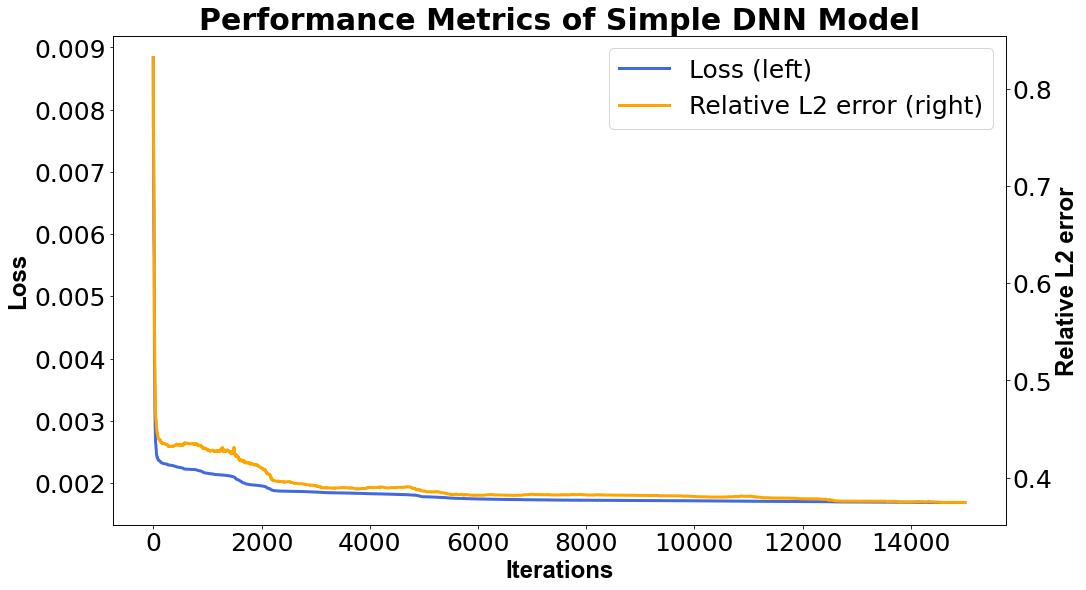

In [21]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Simple DNN Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.017488337523209503
MSE =  0.011632918157611385
RMSE =  0.10785600659032109
L2 relative error = 1.0132213257427038
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

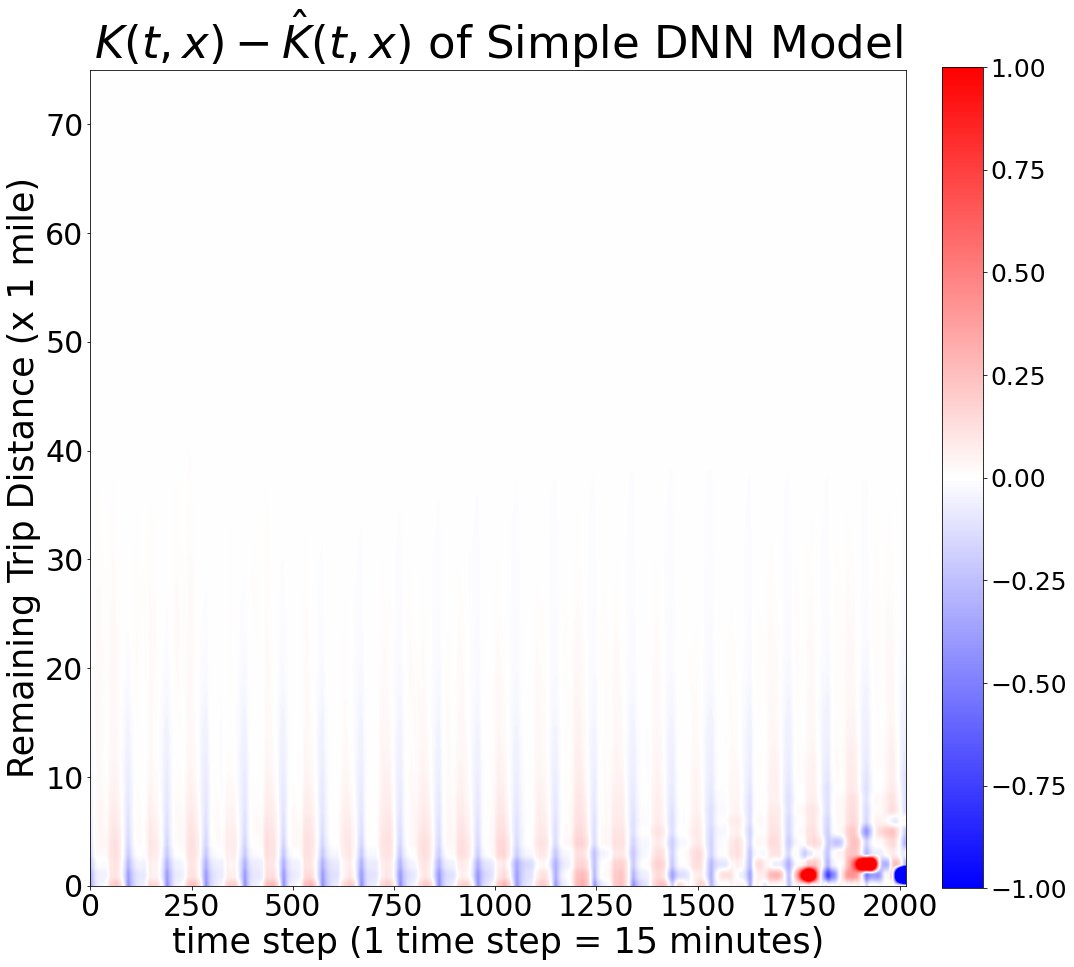

In [22]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

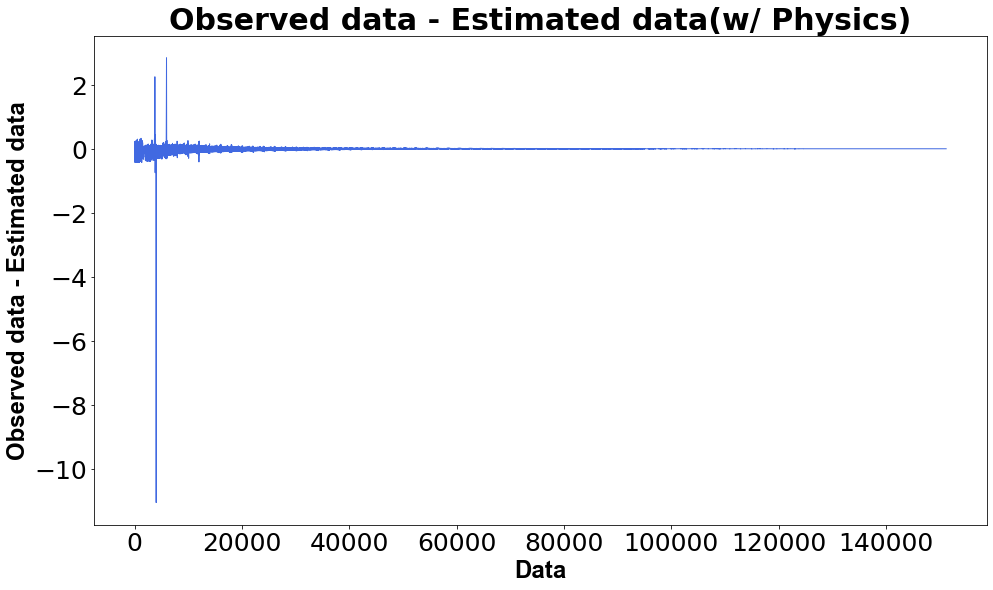

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)